In [1]:
!pip install numpy pandas matplotlib seaborn tqdm scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 154.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 183.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 266.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 244.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 304.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 275.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 152.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 184.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 328.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 242.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 330.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import Counter

def cargar_y_filtrar_datos(directorio="./", min_variacion=0.01, max_longitud_monotona=50):
    """
    Carga datos y filtra secuencias monótonas o con poca variación
    """
    archivos_procesados = [f for f in os.listdir(directorio) 
                          if f.endswith('_procesado.json')]
    
    print(f"Encontrados {len(archivos_procesados)} archivos procesados")
    
    datos_filtrados = []
    datos_descartados = []
    estadisticas_descarte = {
        'total': 0,
        'monotonos': 0,
        'poca_variacion': 0,
        'otros': 0
    }
    
    for archivo in tqdm(archivos_procesados, desc="Cargando y filtrando"):
        try:
            with open(os.path.join(directorio, archivo), 'r') as f:
                datos_archivo = json.load(f)
            
            for agente_data in datos_archivo:
                estadisticas_descarte['total'] += 1
                betting_history, alpha = agente_data
                
                # Convertir a numpy array
                hist_array = np.array(betting_history)
                
                # 1. Verificar si es completamente monótono
                es_monotono = False
                
                # Verificar si todos los valores son iguales
                valores_unicos = np.unique(hist_array)
                if len(valores_unicos) == 1:
                    estadisticas_descarte['monotonos'] += 1
                    datos_descartados.append({
                        'betting_history': betting_history,
                        'alpha': alpha,
                        'razon': 'completamente_monotono',
                        'archivo': archivo
                    })
                    continue
                
                # 2. Verificar secuencias monótonas largas
                # Encontrar la racha más larga del mismo valor
                max_streak = 1
                current_streak = 1
                
                for i in range(1, len(hist_array)):
                    if hist_array[i] == hist_array[i-1]:
                        current_streak += 1
                        max_streak = max(max_streak, current_streak)
                    else:
                        current_streak = 1
                
                # Si la racha más larga es demasiado larga
                if max_streak > max_longitud_monotona:
                    estadisticas_descarte['monotonos'] += 1
                    datos_descartados.append({
                        'betting_history': betting_history,
                        'alpha': alpha,
                        'razon': f'racha_larga_{max_streak}',
                        'archivo': archivo
                    })
                    continue
                
                # 3. Verificar poca variación estadística
                # Calcular proporción de -1 y 1
                prop_positivos = np.sum(hist_array == 1) / len(hist_array)
                prop_negativos = np.sum(hist_array == -1) / len(hist_array)
                
                # Si una proporción es muy dominante
                if prop_positivos > (1 - min_variacion) or prop_negativos > (1 - min_variacion):
                    estadisticas_descarte['poca_variacion'] += 1
                    datos_descartados.append({
                        'betting_history': betting_history,
                        'alpha': alpha,
                        'razon': f'poca_variacion_p{prop_positivos:.3f}_n{prop_negativos:.3f}',
                        'archivo': archivo
                    })
                    continue
                
                # 4. Calcular entropía de la secuencia
                # Entropía más baja = menos información
                p1 = prop_positivos
                p0 = prop_negativos
                
                entropy = 0
                if p1 > 0:
                    entropy -= p1 * np.log2(p1)
                if p0 > 0:
                    entropy -= p0 * np.log2(p0)
                
                # Filtrar por entropía muy baja
                if entropy < 0.1:  # Umbral de entropía
                    estadisticas_descarte['poca_variacion'] += 1
                    datos_descartados.append({
                        'betting_history': betting_history,
                        'alpha': alpha,
                        'razon': f'baja_entropia_{entropy:.3f}',
                        'archivo': archivo
                    })
                    continue
                
                # 5. Pasar todos los filtros - datos válidos
                datos_filtrados.append({
                    'betting_history': betting_history,
                    'alpha': alpha,
                    'archivo_origen': archivo,
                    'prop_positivos': prop_positivos,
                    'prop_negativos': prop_negativos,
                    'entropia': entropy,
                    'max_racha': max_streak
                })
                
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")
    
    return datos_filtrados, datos_descartados, estadisticas_descarte

# Cargar y filtrar datos
datos_filtrados, datos_descartados, estadisticas_descarte = cargar_y_filtrar_datos(
    min_variacion=0.05,  # Mínimo 5% de variación
    max_longitud_monotona=100  # Máximo 100 elementos iguales seguidos
)

print(f"\n=== ESTADÍSTICAS DE FILTRADO ===")
print(f"Total ejemplos procesados: {estadisticas_descarte['total']}")
print(f"Ejemplos aceptados: {len(datos_filtrados)} ({len(datos_filtrados)/estadisticas_descarte['total']*100:.1f}%)")
print(f"Ejemplos descartados: {len(datos_descartados)} ({len(datos_descartados)/estadisticas_descarte['total']*100:.1f}%)")
print(f"  - Completamente monótonos: {estadisticas_descarte['monotonos']}")
print(f"  - Poca variación: {estadisticas_descarte['poca_variacion']}")
print(f"  - Otros: {estadisticas_descarte['otros']}")

Encontrados 30 archivos procesados


Cargando y filtrando: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s] 


=== ESTADÍSTICAS DE FILTRADO ===
Total ejemplos procesados: 7976
Ejemplos aceptados: 3271 (41.0%)
Ejemplos descartados: 4705 (59.0%)
  - Completamente monótonos: 4705
  - Poca variación: 0
  - Otros: 0


=== ANÁLISIS DE DATOS DESCARTADOS ===
Total descartados: 4705

Razones de descarte:
  completamente_monotono: 4705 (100.0%)

Alpha en datos descartados:
  Mínimo: 0.4295
  Máximo: 85.3333
  Media: 1.4691


/tmp/ipykernel_226/3557601804.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot(data_grupos, labels=grupos)


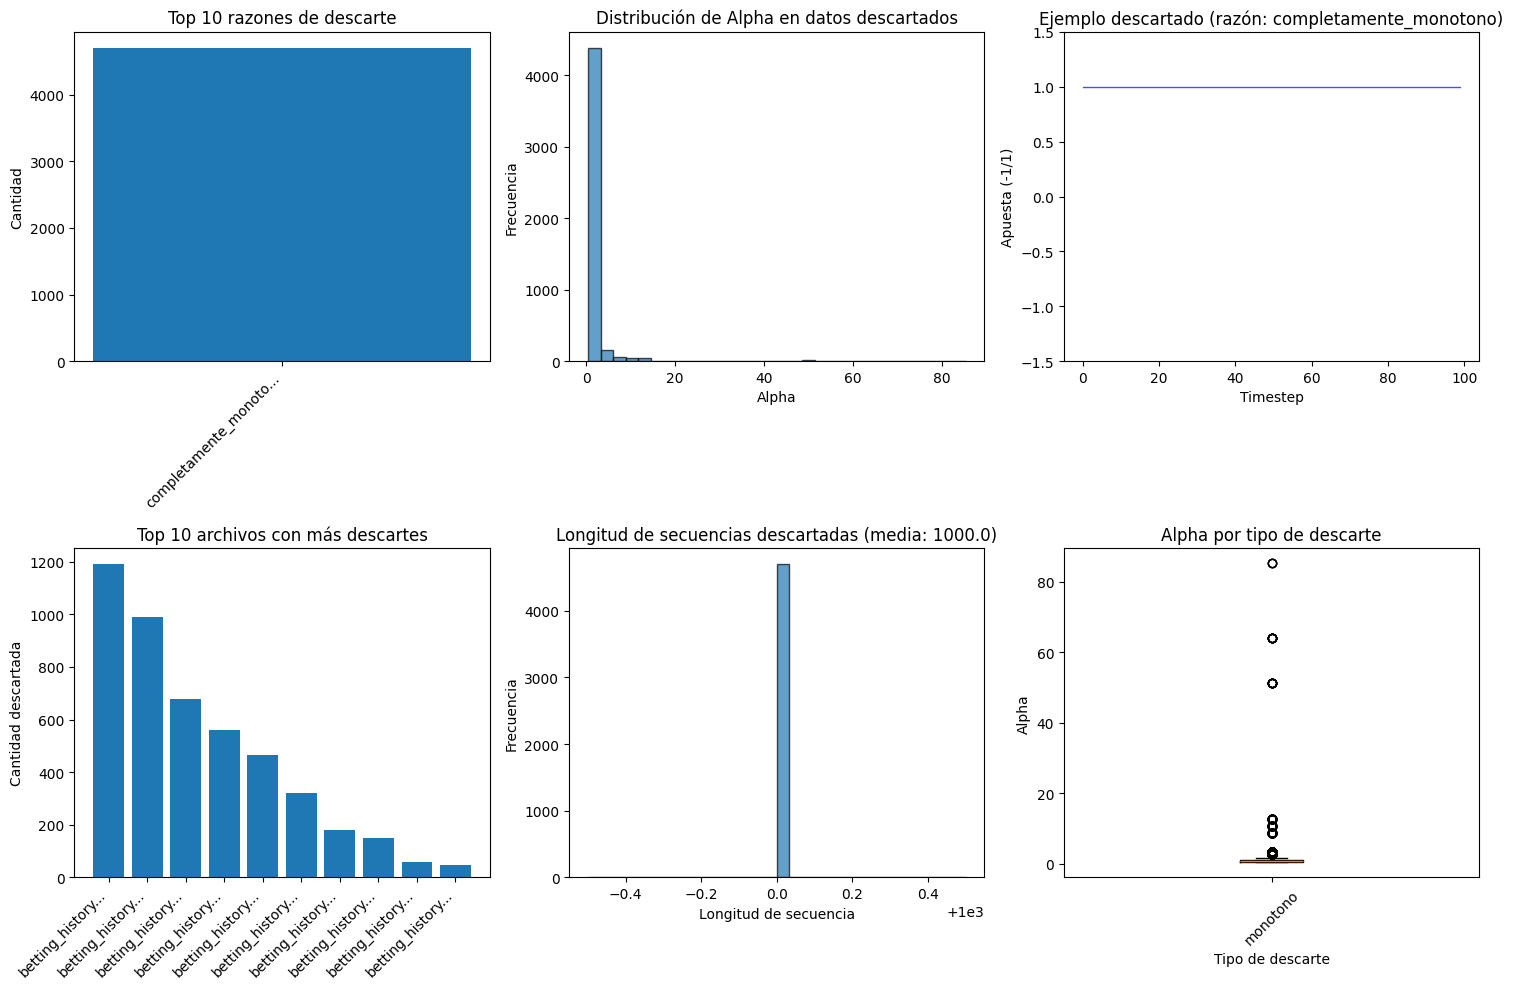

In [3]:
def analizar_datos_descartados(datos_descartados):
    """
    Analiza por qué se descartaron los datos
    """
    if not datos_descartados:
        print("No hay datos descartados para analizar")
        return
    
    # Convertir a DataFrame
    df_descartados = pd.DataFrame(datos_descartados)
    
    # Contar razones
    razones_conteo = df_descartados['razon'].value_counts()
    
    print("=== ANÁLISIS DE DATOS DESCARTADOS ===")
    print(f"Total descartados: {len(df_descartados)}")
    print("\nRazones de descarte:")
    for razon, count in razones_conteo.head(10).items():
        print(f"  {razon}: {count} ({count/len(df_descartados)*100:.1f}%)")
    
    # Analizar distribución de alpha en descartados
    if 'alpha' in df_descartados.columns:
        print(f"\nAlpha en datos descartados:")
        print(f"  Mínimo: {df_descartados['alpha'].min():.4f}")
        print(f"  Máximo: {df_descartados['alpha'].max():.4f}")
        print(f"  Media: {df_descartados['alpha'].mean():.4f}")
    
    # Visualizar
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Razones de descarte
    axes[0, 0].bar(range(len(razones_conteo)), razones_conteo.values[:10])
    axes[0, 0].set_xticks(range(min(10, len(razones_conteo))))
    axes[0, 0].set_xticklabels([r[:20] + '...' for r in razones_conteo.index[:10]], rotation=45, ha='right')
    axes[0, 0].set_title('Top 10 razones de descarte')
    axes[0, 0].set_ylabel('Cantidad')
    
    # 2. Histograma de alpha descartados
    if 'alpha' in df_descartados.columns:
        axes[0, 1].hist(df_descartados['alpha'], bins=30, edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('Alpha')
        axes[0, 1].set_ylabel('Frecuencia')
        axes[0, 1].set_title('Distribución de Alpha en datos descartados')
    
    # 3. Ejemplos de secuencias descartadas
    if len(datos_descartados) > 0:
        ejemplo = datos_descartados[0]['betting_history']
        axes[0, 2].plot(ejemplo[:100], 'b-', alpha=0.7, linewidth=1)
        axes[0, 2].set_xlabel('Timestep')
        axes[0, 2].set_ylabel('Apuesta (-1/1)')
        axes[0, 2].set_title(f'Ejemplo descartado (razón: {datos_descartados[0]["razon"][:30]})')
        axes[0, 2].set_ylim([-1.5, 1.5])
    
    # 4. Por archivo
    if 'archivo' in df_descartados.columns:
        top_archivos = df_descartados['archivo'].value_counts().head(10)
        axes[1, 0].bar(range(len(top_archivos)), top_archivos.values)
        axes[1, 0].set_xticks(range(len(top_archivos)))
        axes[1, 0].set_xticklabels([a[:15] + '...' for a in top_archivos.index], rotation=45, ha='right')
        axes[1, 0].set_title('Top 10 archivos con más descartes')
        axes[1, 0].set_ylabel('Cantidad descartada')
    
    # 5. Longitud de secuencias descartadas
    longitudes = [len(d['betting_history']) for d in datos_descartados]
    axes[1, 1].hist(longitudes, bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Longitud de secuencia')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].set_title(f'Longitud de secuencias descartadas (media: {np.mean(longitudes):.1f})')
    
    # 6. Boxplot de alpha por tipo de descarte
    if 'alpha' in df_descartados.columns and 'razon' in df_descartados.columns:
        # Agrupar razones similares
        df_descartados['razon_grupo'] = df_descartados['razon'].apply(
            lambda x: 'monotono' if 'monotono' in x else 
                     'racha' if 'racha' in x else 
                     'variacion' if 'variacion' in x else 
                     'entropia' if 'entropia' in x else 'otro'
        )
        
        grupos = df_descartados['razon_grupo'].unique()
        data_grupos = [df_descartados[df_descartados['razon_grupo'] == g]['alpha'] for g in grupos]
        
        axes[1, 2].boxplot(data_grupos, labels=grupos)
        axes[1, 2].set_xlabel('Tipo de descarte')
        axes[1, 2].set_ylabel('Alpha')
        axes[1, 2].set_title('Alpha por tipo de descarte')
        axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Analizar datos descartados
analizar_datos_descartados(datos_descartados)

=== ANÁLISIS DE DATOS FILTRADOS ===
Total ejemplos filtrados: 3271
Valores únicos de alpha: 17

Estadísticas de Alpha:
  Mínimo: 0.3558
  Máximo: 102.4000
  Media: 2.5827
  Desviación estándar: 7.5115

Estadísticas de variación:
  Proporción media de 1's: 0.500
  Proporción media de -1's: 0.500
  Entropía media: 0.998
  Máxima racha media: 10.8


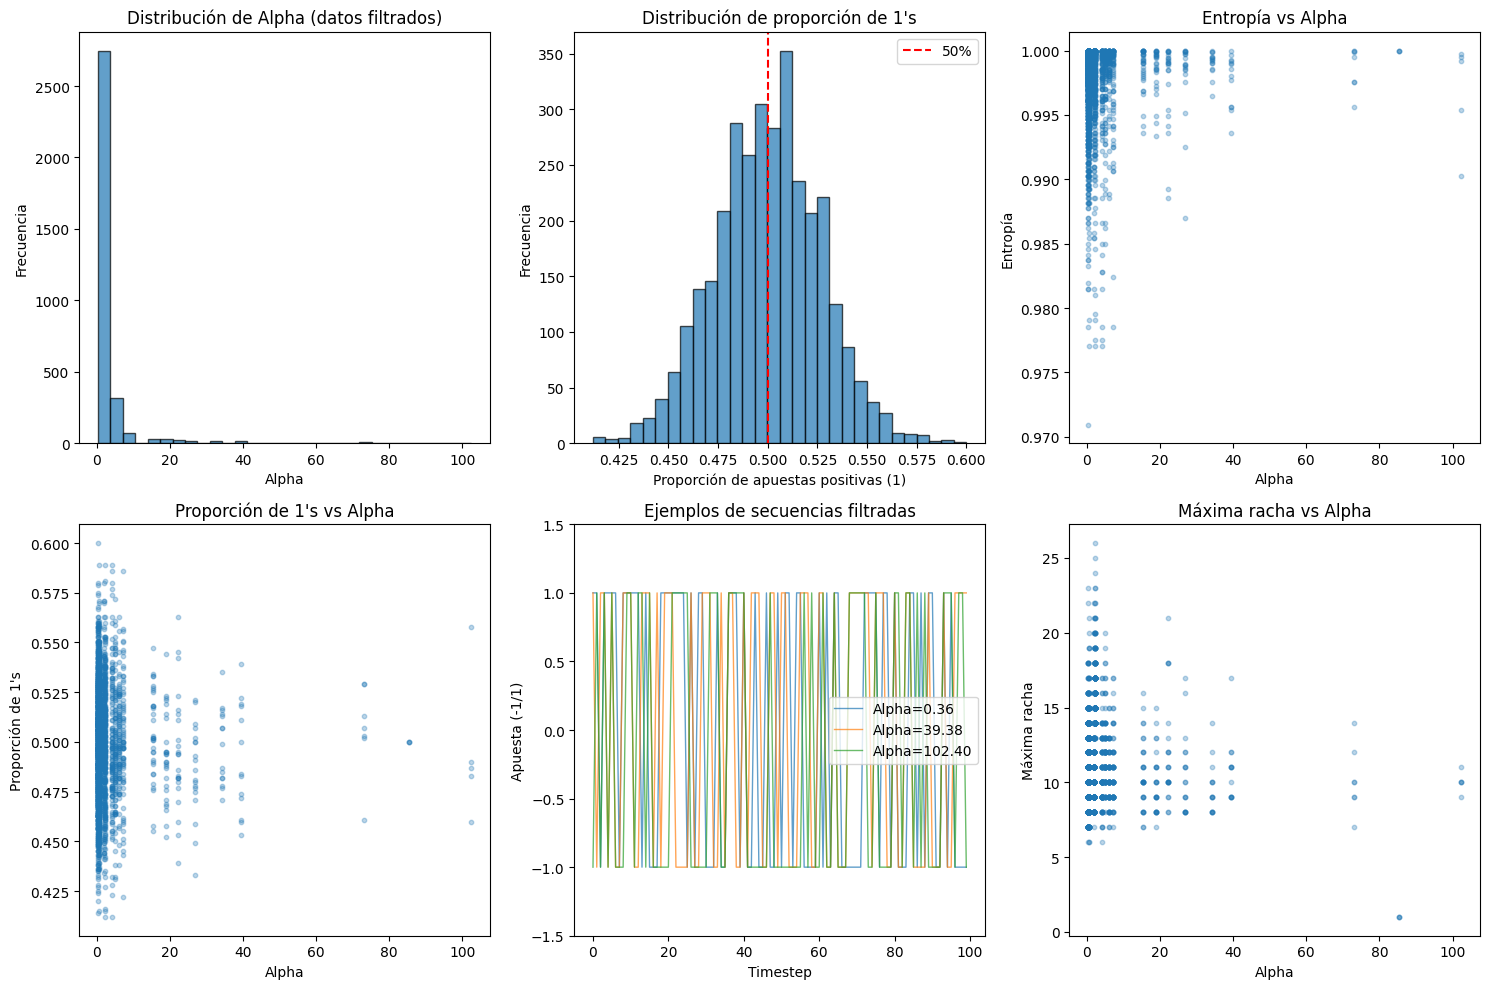


=== CORRELACIONES ===
alpha             1.000000
prop_negativos    0.020983
entropia          0.000348
prop_positivos   -0.020983
max_racha        -0.030060
Name: alpha, dtype: float64


In [4]:
def analizar_datos_filtrados(datos_filtrados):
    """
    Analiza las características de los datos filtrados
    """
    # Convertir a DataFrame
    df_filtrado = pd.DataFrame(datos_filtrados)
    
    print("=== ANÁLISIS DE DATOS FILTRADOS ===")
    print(f"Total ejemplos filtrados: {len(df_filtrado)}")
    print(f"Valores únicos de alpha: {df_filtrado['alpha'].nunique()}")
    
    # Estadísticas de alpha
    print(f"\nEstadísticas de Alpha:")
    print(f"  Mínimo: {df_filtrado['alpha'].min():.4f}")
    print(f"  Máximo: {df_filtrado['alpha'].max():.4f}")
    print(f"  Media: {df_filtrado['alpha'].mean():.4f}")
    print(f"  Desviación estándar: {df_filtrado['alpha'].std():.4f}")
    
    # Estadísticas de variación
    print(f"\nEstadísticas de variación:")
    print(f"  Proporción media de 1's: {df_filtrado['prop_positivos'].mean():.3f}")
    print(f"  Proporción media de -1's: {df_filtrado['prop_negativos'].mean():.3f}")
    print(f"  Entropía media: {df_filtrado['entropia'].mean():.3f}")
    print(f"  Máxima racha media: {df_filtrado['max_racha'].mean():.1f}")
    
    # Visualizar
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Distribución de alpha
    axes[0, 0].hist(df_filtrado['alpha'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Alpha')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].set_title('Distribución de Alpha (datos filtrados)')
    
    # 2. Distribución de proporción de 1's
    axes[0, 1].hist(df_filtrado['prop_positivos'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Proporción de apuestas positivas (1)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de proporción de 1\'s')
    axes[0, 1].axvline(x=0.5, color='r', linestyle='--', label='50%')
    axes[0, 1].legend()
    
    # 3. Entropía vs Alpha
    axes[0, 2].scatter(df_filtrado['alpha'], df_filtrado['entropia'], alpha=0.3, s=10)
    axes[0, 2].set_xlabel('Alpha')
    axes[0, 2].set_ylabel('Entropía')
    axes[0, 2].set_title('Entropía vs Alpha')
    
    # 4. Proporción de 1's vs Alpha
    axes[1, 0].scatter(df_filtrado['alpha'], df_filtrado['prop_positivos'], alpha=0.3, s=10)
    axes[1, 0].set_xlabel('Alpha')
    axes[1, 0].set_ylabel('Proporción de 1\'s')
    axes[1, 0].set_title('Proporción de 1\'s vs Alpha')
    
    # 5. Ejemplos de secuencias filtradas
    # Mostrar ejemplos con diferentes alphas
    unique_alphas = df_filtrado['alpha'].unique()
    sample_indices = []
    
    for target_alpha in np.linspace(df_filtrado['alpha'].min(), 
                                    df_filtrado['alpha'].max(), 3):
        idx = np.argmin(np.abs(df_filtrado['alpha'] - target_alpha))
        sample_indices.append(idx)
    
    for i, idx in enumerate(sample_indices[:3]):
        ejemplo = df_filtrado.iloc[idx]['betting_history']
        axes[1, 1].plot(ejemplo[:100], alpha=0.7, linewidth=1, 
                       label=f'Alpha={df_filtrado.iloc[idx]["alpha"]:.2f}')
    
    axes[1, 1].set_xlabel('Timestep')
    axes[1, 1].set_ylabel('Apuesta (-1/1)')
    axes[1, 1].set_title('Ejemplos de secuencias filtradas')
    axes[1, 1].set_ylim([-1.5, 1.5])
    axes[1, 1].legend()
    
    # 6. Máxima racha vs Alpha
    axes[1, 2].scatter(df_filtrado['alpha'], df_filtrado['max_racha'], alpha=0.3, s=10)
    axes[1, 2].set_xlabel('Alpha')
    axes[1, 2].set_ylabel('Máxima racha')
    axes[1, 2].set_title('Máxima racha vs Alpha')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar correlaciones
    print("\n=== CORRELACIONES ===")
    correlaciones = df_filtrado[['alpha', 'prop_positivos', 'prop_negativos', 'entropia', 'max_racha']].corr()
    print(correlaciones['alpha'].sort_values(ascending=False))
    
    return df_filtrado

# Analizar datos filtrados
df_filtrado = analizar_datos_filtrados(datos_filtrados)

In [8]:
def filtrar_datos_avanzado(datos, config):
    """
    Filtrado avanzado con múltiples criterios
    """
    datos_filtrados = []
    estadisticas = {
        'total': 0,
        'aceptados': 0,
        'descartados_razon': {}
    }
    
    for dato in tqdm(datos, desc="Filtrando datos avanzado"):
        estadisticas['total'] += 1
        betting_history = dato['betting_history']
        alpha = dato['alpha']
        
        # Convertir a numpy
        hist = np.array(betting_history)
        
        # Calcular métricas
        n = len(hist)
        prop_pos = np.sum(hist == 1) / n
        prop_neg = np.sum(hist == -1) / n
        
        # Entropía
        entropy = 0
        if prop_pos > 0:
            entropy -= prop_pos * np.log2(prop_pos)
        if prop_neg > 0:
            entropy -= prop_neg * np.log2(prop_neg)
        
        # Máxima racha
        max_streak = 1
        current = 1
        for i in range(1, n):
            if hist[i] == hist[i-1]:
                current += 1
                max_streak = max(max_streak, current)
            else:
                current = 1
        
        # Cambios de signo (transiciones)
        cambios = np.sum(hist[1:] != hist[:-1])
        tasa_cambios = cambios / (n - 1) if n > 1 else 0
        
        # Autocorrelación en lag 1
        if n > 1:
            autocorr = np.corrcoef(hist[:-1], hist[1:])[0, 1]
        else:
            autocorr = 0
        
        # Aplicar filtros
        razon_descarte = None
        
        # 1. Completamente monótono
        if len(np.unique(hist)) == 1:
            razon_descarte = 'completamente_monotono'
        
        # 2. Máxima racha demasiado larga
        elif max_streak > config['max_racha']:
            razon_descarte = f'racha_demasiado_larga_{max_streak}'
        
        # 3. Proporción muy desbalanceada
        elif (prop_pos > config['max_prop_dominante'] or 
              prop_neg > config['max_prop_dominante']):
            razon_descarte = f'proporcion_desbalanceada_p{prop_pos:.3f}'
        
        # 4. Entropía muy baja
        elif entropy < config['min_entropia']:
            razon_descarte = f'entropia_baja_{entropy:.3f}'
        
        # 5. Tasa de cambios muy baja
        elif tasa_cambios < config['min_tasa_cambios']:
            razon_descarte = f'tasa_cambios_baja_{tasa_cambios:.3f}'
        
        # 6. Autocorrelación muy alta (demasiado predecible)
        elif abs(autocorr) > config['max_autocorr']:
            razon_descarte = f'autocorrelacion_alta_{autocorr:.3f}'
        
        # 7. Secuencia demasiado corta (si aplica)
        if 'min_longitud' in config and n < config['min_longitud']:
            razon_descarte = f'secuencia_corta_{n}'
        
        # Si pasa todos los filtros
        if razon_descarte is None:
            estadisticas['aceptados'] += 1
            datos_filtrados.append({
                'betting_history': betting_history,
                'alpha': alpha,
                'prop_positivos': prop_pos,
                'prop_negativos': prop_neg,
                'entropia': entropy,
                'max_racha': max_streak,
                'tasa_cambios': tasa_cambios,
                'autocorrelacion': autocorr,
                'cambios_signo': cambios
            })
        else:
            # Registrar razón de descarte
            if razon_descarte not in estadisticas['descartados_razon']:
                estadisticas['descartados_razon'][razon_descarte] = 0
            estadisticas['descartados_razon'][razon_descarte] += 1
    
    return datos_filtrados, estadisticas

# Configuración de filtrado avanzado
config_filtrado = {
    'max_racha': 100,           # Máximo 100 elementos iguales seguidos
    'max_prop_dominante': 0.95, # Máximo 95% de un tipo de apuesta
    'min_entropia': 0.3,        # Mínima entropía de 0.3 bits
    'min_tasa_cambios': 0.01,   # Mínimo 1% de cambios entre timesteps
    'max_autocorr': 0.95,       # Máxima autocorrelación de 0.95
    'min_longitud': 500         # Mínimo 500 elementos (si queremos filtrar cortos)
}

print("\n=== FILTRADO AVANZADO ===")
print("Configuración:")
for key, value in config_filtrado.items():
    print(f"  {key}: {value}")

# Aplicar filtrado avanzado a los datos originales
# Primero necesitamos cargar los datos sin filtrar
def cargar_datos_sin_filtrar(directorio="./"):
    """Carga datos sin ningún filtro"""
    archivos_procesados = [f for f in os.listdir(directorio) 
                          if f.endswith('_procesado.json')]
    
    datos_sin_filtrar = []
    
    for archivo in tqdm(archivos_procesados, desc="Cargando datos sin filtrar"):
        try:
            with open(os.path.join(directorio, archivo), 'r') as f:
                datos_archivo = json.load(f)
            
            for agente_data in datos_archivo:
                betting_history, alpha = agente_data
                datos_sin_filtrar.append({
                    'betting_history': betting_history,
                    'alpha': alpha,
                    'archivo_origen': archivo
                })
                
        except Exception as e:
            print(f"Error cargando {archivo}: {e}")
    
    return datos_sin_filtrar

# Cargar datos sin filtrar
datos_sin_filtrar = cargar_datos_sin_filtrar()

# Aplicar filtrado avanzado
datos_filtrados_avanzado, estadisticas_avanzado = filtrar_datos_avanzado(
    datos_sin_filtrar, config_filtrado
)

print(f"\nResultados filtrado avanzado:")
print(f"Total procesados: {estadisticas_avanzado['total']}")
print(f"Aceptados: {estadisticas_avanzado['aceptados']} ({estadisticas_avanzado['aceptados']/estadisticas_avanzado['total']*100:.1f}%)")
print(f"Descartados: {estadisticas_avanzado['total'] - estadisticas_avanzado['aceptados']}")

print("\nRazones de descarte (top 10):")
razones_ordenadas = sorted(estadisticas_avanzado['descartados_razon'].items(), 
                          key=lambda x: x[1], reverse=True)
for razon, count in razones_ordenadas[:10]:
    print(f"  {razon}: {count}")

# Usar los datos filtrados avanzado para entrenamiento
datos_para_entrenar = datos_filtrados_avanzado


=== FILTRADO AVANZADO ===
Configuración:
  max_racha: 100
  max_prop_dominante: 0.95
  min_entropia: 0.3
  min_tasa_cambios: 0.01
  max_autocorr: 0.95
  min_longitud: 500


Filtrando datos avanzado:   0%|          | 0/7976 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
Filtrando datos avanzado: 100%|██████████| 7976/7976 [00:03<00:00, 2036.85it/s]


Resultados filtrado avanzado:
Total procesados: 7976
Aceptados: 3268 (41.0%)
Descartados: 4708

Razones de descarte (top 10):
  completamente_monotono: 4705
  autocorrelacion_alta_-1.000: 3


In [10]:
from sklearn.model_selection import train_test_split

def preparar_datos_entrenamiento(datos_filtrados, test_size=0.2, val_size=0.15):
    """
    Prepara datos filtrados para entrenamiento
    """
    # Mezclar aleatoriamente
    random.shuffle(datos_filtrados)
    
    X = []
    y = []
    metadata = []
    
    for dato in datos_filtrados:
        X.append(dato['betting_history'])
        y.append(dato['alpha'])
        metadata.append({
            'prop_positivos': dato.get('prop_positivos', 0.5),
            'entropia': dato.get('entropia', 1.0),
            'max_racha': dato.get('max_racha', 1)
        })
    
    X = np.array(X)
    y = np.array(y)
    metadata = np.array(metadata)
    
    print(f"Datos para entrenamiento:")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    print(f"  Rango alpha: [{y.min():.4f}, {y.max():.4f}]")
    print(f"  Alpha único: {len(np.unique(y))}")
    
    # Dividir en train/test/val
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, shuffle=True
    )
    
    val_relative = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_relative, random_state=42, shuffle=True
    )
    
    print(f"\nDivisión:")
    print(f"  Train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"  Validation: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"  Test: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Verificar que no haya datos monótonos en los conjuntos
    def verificar_no_monotonos(X_set, nombre):
        monotono_count = 0
        for seq in X_set:
            if len(np.unique(seq)) == 1:
                monotono_count += 1
        
        if monotono_count > 0:
            print(f"  ADVERTENCIA: {nombre} tiene {monotono_count} secuencias monótonas!")
        else:
            print(f"  OK: {nombre} no tiene secuencias monótonas")
    
    print("\nVerificación de no monotonía:")
    verificar_no_monotonos(X_train, "Train")
    verificar_no_monotonos(X_val, "Validation")
    verificar_no_monotonos(X_test, "Test")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Preparar datos filtrados
X_train, X_val, X_test, y_train, y_val, y_test = preparar_datos_entrenamiento(
    datos_para_entrenar
)

Datos para entrenamiento:
  X shape: (3268, 1000)
  y shape: (3268,)
  Rango alpha: [0.3558, 102.4000]
  Alpha único: 16

División:
  Train: 2123 (65.0%)
  Validation: 491 (15.0%)
  Test: 654 (20.0%)

Verificación de no monotonía:
  OK: Train no tiene secuencias monótonas
  OK: Validation no tiene secuencias monótonas
  OK: Test no tiene secuencias monótonas


In [20]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [13]:
def procesar_secuencias_final(X_train, X_val, X_test):
    """
    Procesamiento final de secuencias para RNN
    """
    # Convertir -1,1 a 0,1
    X_train_proc = (X_train + 1) / 2
    X_val_proc = (X_val + 1) / 2
    X_test_proc = (X_test + 1) / 2
    
    # Reshape para RNN
    X_train_proc = X_train_proc.reshape(X_train_proc.shape[0], 
                                       X_train_proc.shape[1], 1)
    X_val_proc = X_val_proc.reshape(X_val_proc.shape[0], 
                                   X_val_proc.shape[1], 1)
    X_test_proc = X_test_proc.reshape(X_test_proc.shape[0], 
                                     X_test_proc.shape[1], 1)
    
    print(f"\nForma después de procesamiento:")
    print(f"  X_train: {X_train_proc.shape}")
    print(f"  X_val: {X_val_proc.shape}")
    print(f"  X_test: {X_test_proc.shape}")
    
    return X_train_proc, X_val_proc, X_test_proc

def normalizar_target_final(y_train, y_val, y_test):
    """
    Normalización final del target
    """
    scaler = StandardScaler()
    
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    print(f"\nNormalización de alpha:")
    print(f"  Media original: {y_train.mean():.4f}")
    print(f"  Std original: {y_train.std():.4f}")
    print(f"  Media escalada: {y_train_scaled.mean():.4f}")
    print(f"  Std escalada: {y_train_scaled.std():.4f}")
    
    return y_train_scaled, y_val_scaled, y_test_scaled, scaler

# Procesar secuencias
X_train_proc, X_val_proc, X_test_proc = procesar_secuencias_final(
    X_train, X_val, X_test
)

# Normalizar target
y_train_scaled, y_val_scaled, y_test_scaled, y_scaler = normalizar_target_final(
    y_train, y_val, y_test
)


Forma después de procesamiento:
  X_train: (2123, 1000, 1)
  X_val: (491, 1000, 1)
  X_test: (654, 1000, 1)

Normalización de alpha:
  Media original: 2.5020
  Std original: 7.1547
  Media escalada: 0.0000
  Std escalada: 1.0000


In [17]:
def build_gru_model(input_shape, units=[128, 64, 32], dropout_rate=0.3, 
                   use_batch_norm=True, bidirectional=False):
    """
    Construye un modelo GRU para regresión
    """
    inputs = layers.Input(shape=input_shape)
    
    x = inputs
    
    # Capas GRU
    for i, unit in enumerate(units):
        return_sequences = (i < len(units) - 1)  # True para todas excepto la última
        
        if bidirectional:
            x = layers.Bidirectional(
                layers.GRU(unit, 
                          return_sequences=return_sequences,
                          dropout=dropout_rate,
                          recurrent_dropout=dropout_rate/2)
            )(x)
        else:
            x = layers.GRU(unit, 
                          return_sequences=return_sequences,
                          dropout=dropout_rate,
                          recurrent_dropout=dropout_rate/2)(x)
        
        if use_batch_norm and return_sequences:
            x = layers.BatchNormalization()(x)
    
    # Capas densas
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(dropout_rate/2)(x)
    
    x = layers.Dense(16, activation='relu')(x)
    
    # Capa de salida (regresión)
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

# Construir modelo
input_shape = (X_train_proc.shape[1], X_train_proc.shape[2])
model = build_gru_model(input_shape, units=[128, 64, 32], 
                       bidirectional=False, dropout_rate=0.3)

# Compilar
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.summary()

# Visualizar arquitectura
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("\nArquitectura del modelo guardada como 'model_architecture.png'")
except:
    pass

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1000, 128)      │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 1000, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,081 (398.75 KB)

 Non-trainable params: 384 (1.50 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

Arquitectura del modelo guardada como 'model_architecture.png'


In [18]:
pip install pydot


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
def get_callbacks(model_name='best_model'):
    """
    Define callbacks para el entrenamiento
    """
    callbacks_list = [
        # Early Stopping
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        
        # Reduce Learning Rate on Plateau
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        
        # Model Checkpoint
        callbacks.ModelCheckpoint(
            filepath=f'{model_name}.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        
        # TensorBoard (opcional)
        # callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
    ]
    
    return callbacks_list

callbacks_list = get_callbacks('alpha_predictor_gru')

In [22]:
def entrenar_modelo(model, X_train, y_train, X_val, y_val, callbacks_list, 
                   epochs=100, batch_size=32, verbose=1):
    """
    Entrena el modelo y devuelve el historial
    """
    print("=" * 60)
    print("INICIANDO ENTRENAMIENTO")
    print("=" * 60)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=verbose,
        shuffle=True  # Importante: mezclar en cada época
    )
    
    return history

# Entrenar modelo
history = entrenar_modelo(
    model, 
    X_train_proc, y_train_scaled,
    X_val_proc, y_val_scaled,
    callbacks_list,
    epochs=100,
    batch_size=32,
    verbose=1
)

INICIANDO ENTRENAMIENTO
Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.9048 - mae: 0.4367 - rmse: 0.9478
Epoch 1: val_loss improved from None to 0.48809, saving model to alpha_predictor_gru.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 484s 7s/step - loss: 1.0390 - mae: 0.4171 - rmse: 1.0193 - val_loss: 0.4881 - val_mae: 0.3764 - val_rmse: 0.6986 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.9463 - mae: 0.4093 - rmse: 0.9587
Epoch 2: val_loss improved from 0.48809 to 0.48717, saving model to alpha_predictor_gru.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 469s 7s/step - loss: 1.0076 - mae: 0.4145 - rmse: 1.0038 - val_loss: 0.4872 - val_mae: 0.3776 - val_rmse: 0.6980 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.8347 - mae: 0.3868 - rmse: 0.9043
Epoch 3: val_loss did not improve from 0.48717
67/67 ━━━━━━━━━━━━━━━━━━━━ 472s 7s/step - loss: 1.0101 - mae: 0.4122 - rmse: 1.0050 - val_loss: 0.4911 - val_mae: 0.4004 - val_rmse: 0

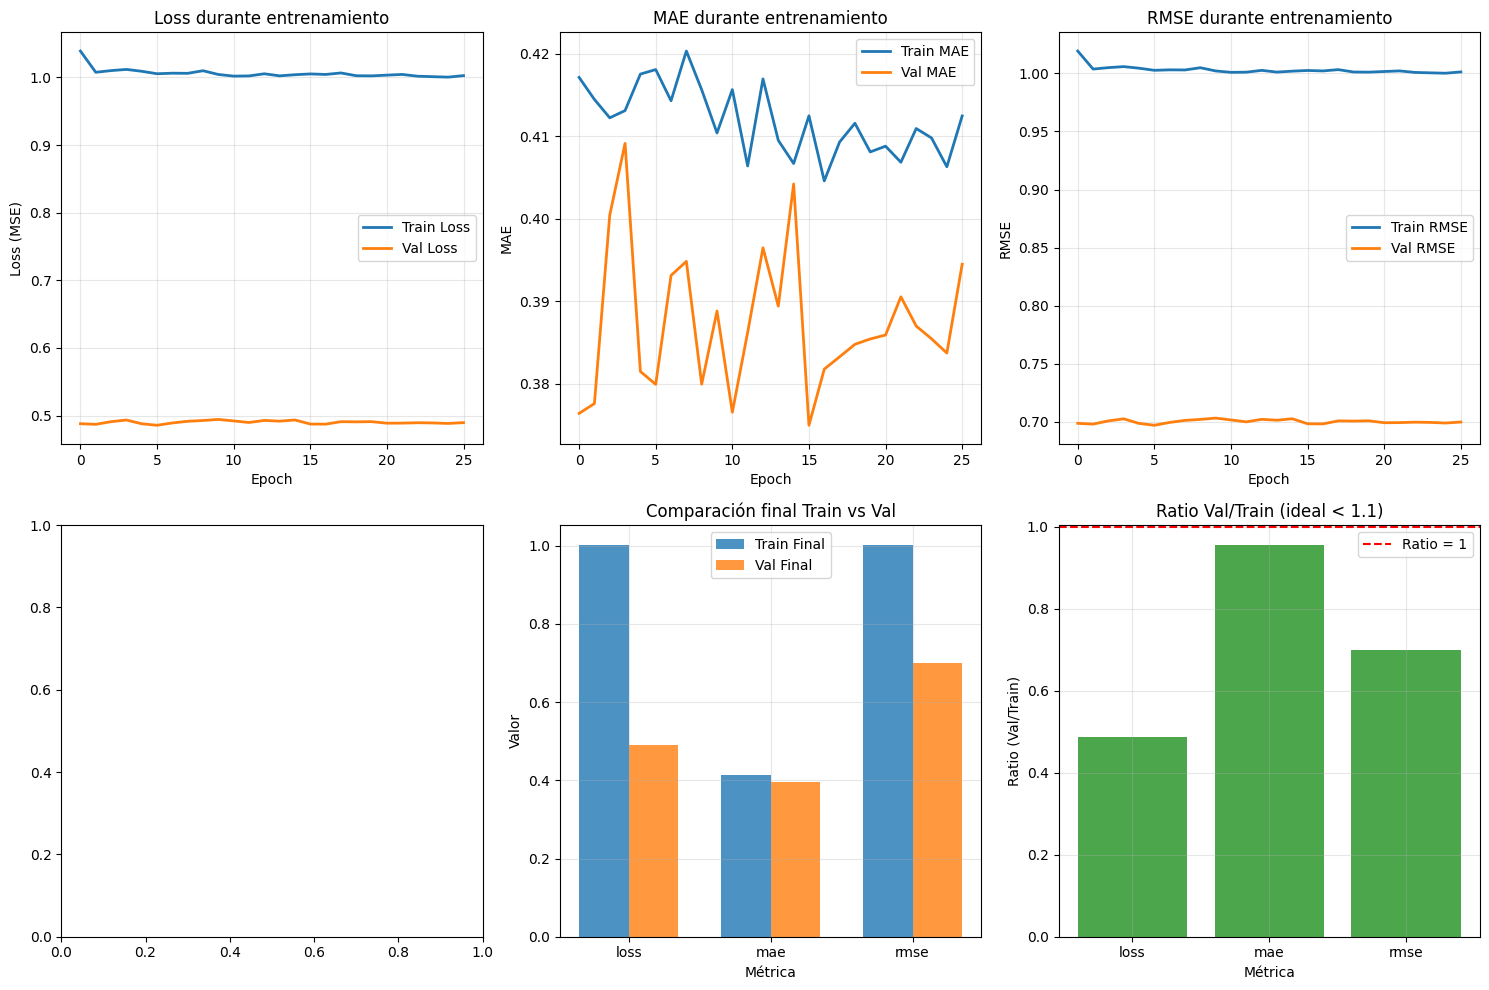


ESTADÍSTICAS FINALES DEL ENTRENAMIENTO
Mejor época: 6
Épocas totales entrenadas: 26
LOSS: Train=1.0054, Val=0.4858, Ratio=0.483
MAE: Train=0.4181, Val=0.3799, Ratio=0.909
RMSE: Train=1.0027, Val=0.6970, Ratio=0.695


In [23]:
def plot_training_history(history):
    """
    Visualiza el historial de entrenamiento
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Loss durante entrenamiento')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAE
    axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].set_title('MAE durante entrenamiento')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # RMSE
    if 'rmse' in history.history:
        axes[0, 2].plot(history.history['rmse'], label='Train RMSE', linewidth=2)
        axes[0, 2].plot(history.history['val_rmse'], label='Val RMSE', linewidth=2)
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('RMSE')
        axes[0, 2].set_title('RMSE durante entrenamiento')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # Learning Rate
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='red')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate durante entrenamiento')
        axes[1, 0].set_yscale('log')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Comparación final train vs val
    final_epoch = len(history.history['loss'])
    metrics = ['loss', 'mae']
    if 'rmse' in history.history:
        metrics.append('rmse')
    
    train_final = [history.history[m][-1] for m in metrics]
    val_final = [history.history[f'val_{m}'][-1] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, train_final, width, label='Train Final', alpha=0.8)
    axes[1, 1].bar(x + width/2, val_final, width, label='Val Final', alpha=0.8)
    axes[1, 1].set_xlabel('Métrica')
    axes[1, 1].set_ylabel('Valor')
    axes[1, 1].set_title('Comparación final Train vs Val')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metrics)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Ratio Val/Train
    ratios = [val_final[i]/train_final[i] for i in range(len(metrics))]
    axes[1, 2].bar(metrics, ratios, alpha=0.7, color='green')
    axes[1, 2].axhline(y=1, color='r', linestyle='--', label='Ratio = 1')
    axes[1, 2].set_xlabel('Métrica')
    axes[1, 2].set_ylabel('Ratio (Val/Train)')
    axes[1, 2].set_title('Ratio Val/Train (ideal < 1.1)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    print("\n" + "="*60)
    print("ESTADÍSTICAS FINALES DEL ENTRENAMIENTO")
    print("="*60)
    
    best_epoch = np.argmin(history.history['val_loss']) + 1
    print(f"Mejor época: {best_epoch}")
    print(f"Épocas totales entrenadas: {len(history.history['loss'])}")
    
    for metric in ['loss', 'mae', 'rmse']:
        if metric in history.history:
            train_val = history.history[metric][best_epoch-1]
            val_val = history.history[f'val_{metric}'][best_epoch-1]
            print(f"{metric.upper()}: Train={train_val:.4f}, Val={val_val:.4f}, Ratio={val_val/train_val:.3f}")

# Visualizar historial
plot_training_history(history)

In [26]:
def guardar_todas_las_imagenes_notebook(datos_filtrados=None, datos_descartados=None):
    """
    Función universal que guarda TODAS las imágenes de tu análisis
    Versión COMPLETA con todo el código incluido
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
    import seaborn as sns
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta_base = f"analisis_completo_{timestamp}"
    os.makedirs(carpeta_base, exist_ok=True)
    
    print(f"📁 Carpeta base: {carpeta_base}/")
    print("=" * 60)
    
    # =================================================================
    # 1. FUNCIÓN PARA GUARDAR IMÁGENES DE DATOS DESCARTADOS
    # =================================================================
    def guardar_imagenes_descartados_interna(datos_descartados, carpeta_destino):
        """Versión interna para guardar imágenes de datos descartados"""
        if not datos_descartados:
            return 0
        
        df_descartados = pd.DataFrame(datos_descartados)
        imagenes_guardadas = 0
        
        # 1. Top 10 razones de descarte
        plt.figure(figsize=(10, 6))
        razones_conteo = df_descartados['razon'].value_counts()
        plt.bar(range(len(razones_conteo.head(10))), razones_conteo.values[:10])
        plt.xticks(range(min(10, len(razones_conteo))), 
                   [r[:20] + '...' for r in razones_conteo.index[:10]], 
                   rotation=45, ha='right')
        plt.title('Top 10 razones de descarte')
        plt.ylabel('Cantidad')
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/01_razones_descarte.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 2. Histograma de alpha descartados
        if 'alpha' in df_descartados.columns:
            plt.figure(figsize=(10, 6))
            plt.hist(df_descartados['alpha'], bins=30, edgecolor='black', alpha=0.7)
            plt.xlabel('Alpha')
            plt.ylabel('Frecuencia')
            plt.title('Distribución de Alpha en datos descartados')
            plt.tight_layout()
            plt.savefig(f'{carpeta_destino}/02_histograma_alpha.png', dpi=300)
            plt.close()
            imagenes_guardadas += 1
        
        # 3. Ejemplo de secuencia descartada
        if len(datos_descartados) > 0:
            plt.figure(figsize=(10, 6))
            ejemplo = datos_descartados[0]['betting_history']
            plt.plot(ejemplo[:100], 'b-', alpha=0.7, linewidth=1)
            plt.xlabel('Timestep')
            plt.ylabel('Apuesta (-1/1)')
            plt.title(f'Ejemplo descartado')
            plt.ylim([-1.5, 1.5])
            plt.tight_layout()
            plt.savefig(f'{carpeta_destino}/03_ejemplo_secuencia.png', dpi=300)
            plt.close()
            imagenes_guardadas += 1
        
        # 4. Top 10 archivos con más descartes
        if 'archivo' in df_descartados.columns:
            plt.figure(figsize=(10, 6))
            top_archivos = df_descartados['archivo'].value_counts().head(10)
            plt.bar(range(len(top_archivos)), top_archivos.values)
            plt.xticks(range(len(top_archivos)), 
                       [a[:15] + '...' for a in top_archivos.index], 
                       rotation=45, ha='right')
            plt.title('Top 10 archivos con más descartes')
            plt.ylabel('Cantidad descartada')
            plt.tight_layout()
            plt.savefig(f'{carpeta_destino}/04_top_archivos.png', dpi=300)
            plt.close()
            imagenes_guardadas += 1
        
        # 5. Longitud de secuencias descartadas
        plt.figure(figsize=(10, 6))
        longitudes = [len(d['betting_history']) for d in datos_descartados]
        plt.hist(longitudes, bins=30, edgecolor='black', alpha=0.7)
        plt.xlabel('Longitud de secuencia')
        plt.ylabel('Frecuencia')
        plt.title(f'Longitud de secuencias descartadas (media: {np.mean(longitudes):.1f})')
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/05_longitud_secuencias.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 6. Boxplot de alpha por tipo de descarte
        if 'alpha' in df_descartados.columns and 'razon' in df_descartados.columns:
            plt.figure(figsize=(10, 6))
            df_descartados['razon_grupo'] = df_descartados['razon'].apply(
                lambda x: 'monotono' if 'monotono' in x else 
                         'racha' if 'racha' in x else 
                         'variacion' if 'variacion' in x else 
                         'entropia' if 'entropia' in x else 'otro'
            )
            
            grupos = df_descartados['razon_grupo'].unique()
            data_grupos = [df_descartados[df_descartados['razon_grupo'] == g]['alpha'] 
                          for g in grupos]
            
            plt.boxplot(data_grupos, labels=grupos)
            plt.xlabel('Tipo de descarte')
            plt.ylabel('Alpha')
            plt.title('Alpha por tipo de descarte')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f'{carpeta_destino}/06_boxplot_alpha.png', dpi=300)
            plt.close()
            imagenes_guardadas += 1
        
        # Guardar estadísticas
        with open(f'{carpeta_destino}/estadisticas_descartados.txt', 'w') as f:
            f.write("=== ESTADÍSTICAS DATOS DESCARTADOS ===\n")
            f.write(f"Total descartados: {len(df_descartados)}\n")
            if 'alpha' in df_descartados.columns:
                f.write(f"\nAlpha en datos descartados:\n")
                f.write(f"  Mínimo: {df_descartados['alpha'].min():.4f}\n")
                f.write(f"  Máximo: {df_descartados['alpha'].max():.4f}\n")
                f.write(f"  Media: {df_descartados['alpha'].mean():.4f}\n")
            
            f.write(f"\nRazones de descarte (top 10):\n")
            for razon, count in razones_conteo.head(10).items():
                f.write(f"  {razon}: {count} ({count/len(df_descartados)*100:.1f}%)\n")
        
        return imagenes_guardadas
    
    # =================================================================
    # 2. FUNCIÓN PARA GUARDAR IMÁGENES DE DATOS FILTRADOS
    # =================================================================
    def guardar_imagenes_filtrados_interna(datos_filtrados, carpeta_destino):
        """Versión interna para guardar imágenes de datos filtrados"""
        if not datos_filtrados:
            return 0
        
        df_filtrado = pd.DataFrame(datos_filtrados)
        imagenes_guardadas = 0
        
        # 1. Distribución de Alpha
        plt.figure(figsize=(10, 6))
        plt.hist(df_filtrado['alpha'], bins=30, edgecolor='black', alpha=0.7)
        plt.xlabel('Alpha')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de Alpha (datos filtrados)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/01_distribucion_alpha.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 2. Distribución de proporción de 1's
        plt.figure(figsize=(10, 6))
        plt.hist(df_filtrado['prop_positivos'], bins=30, edgecolor='black', alpha=0.7)
        plt.xlabel('Proporción de apuestas positivas (1)')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de proporción de 1\'s')
        plt.axvline(x=0.5, color='r', linestyle='--', label='50%')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/02_proporcion_1s.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 3. Entropía vs Alpha
        plt.figure(figsize=(10, 6))
        plt.scatter(df_filtrado['alpha'], df_filtrado['entropia'], alpha=0.3, s=10)
        plt.xlabel('Alpha')
        plt.ylabel('Entropía')
        plt.title('Entropía vs Alpha')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/03_entropia_vs_alpha.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 4. Proporción de 1's vs Alpha
        plt.figure(figsize=(10, 6))
        plt.scatter(df_filtrado['alpha'], df_filtrado['prop_positivos'], alpha=0.3, s=10)
        plt.xlabel('Alpha')
        plt.ylabel('Proporción de 1\'s')
        plt.title('Proporción de 1\'s vs Alpha')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/04_proporcion_vs_alpha.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 5. Ejemplos de secuencias filtradas
        plt.figure(figsize=(10, 6))
        sample_indices = []
        for target_alpha in np.linspace(df_filtrado['alpha'].min(), 
                                        df_filtrado['alpha'].max(), 3):
            idx = np.argmin(np.abs(df_filtrado['alpha'] - target_alpha))
            sample_indices.append(idx)
        
        for i, idx in enumerate(sample_indices[:3]):
            ejemplo = df_filtrado.iloc[idx]['betting_history']
            alpha_val = df_filtrado.iloc[idx]['alpha']
            plt.plot(ejemplo[:100], alpha=0.7, linewidth=1, 
                    label=f'Alpha={alpha_val:.2f}')
        
        plt.xlabel('Timestep')
        plt.ylabel('Apuesta (-1/1)')
        plt.title('Ejemplos de secuencias filtradas')
        plt.ylim([-1.5, 1.5])
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/05_ejemplos_secuencias.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 6. Máxima racha vs Alpha
        plt.figure(figsize=(10, 6))
        plt.scatter(df_filtrado['alpha'], df_filtrado['max_racha'], alpha=0.3, s=10)
        plt.xlabel('Alpha')
        plt.ylabel('Máxima racha')
        plt.title('Máxima racha vs Alpha')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/06_max_racha_vs_alpha.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 7. Matriz de correlaciones
        plt.figure(figsize=(8, 6))
        correlaciones = df_filtrado[['alpha', 'prop_positivos', 'prop_negativos', 
                                    'entropia', 'max_racha']].corr()
        sns.heatmap(correlaciones, annot=True, cmap='coolwarm', center=0, 
                    square=True, cbar_kws={"shrink": 0.8})
        plt.title('Matriz de correlaciones')
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/07_matriz_correlaciones.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # 8. Gráfico combinado (resumen)
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Subplot 1: Distribución alpha
        axes[0, 0].hist(df_filtrado['alpha'], bins=30, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('Distribución Alpha')
        axes[0, 0].set_xlabel('Alpha')
        
        # Subplot 2: Entropía vs Alpha
        axes[0, 1].scatter(df_filtrado['alpha'], df_filtrado['entropia'], alpha=0.3, s=10)
        axes[0, 1].set_title('Entropía vs Alpha')
        
        # Subplot 3: Proporción vs Alpha
        axes[0, 2].scatter(df_filtrado['alpha'], df_filtrado['prop_positivos'], alpha=0.3, s=10)
        axes[0, 2].set_title('Proporción 1\'s vs Alpha')
        
        # Subplot 4: Ejemplo secuencias
        for idx in sample_indices[:2]:
            ejemplo = df_filtrado.iloc[idx]['betting_history'][:50]
            axes[1, 0].plot(ejemplo, alpha=0.7)
        axes[1, 0].set_title('Ejemplos secuencias')
        axes[1, 0].set_ylim([-1.5, 1.5])
        
        # Subplot 5: Máxima racha
        axes[1, 1].scatter(df_filtrado['alpha'], df_filtrado['max_racha'], alpha=0.3, s=10)
        axes[1, 1].set_title('Máxima racha vs Alpha')
        
        # Subplot 6: Histograma proporción
        axes[1, 2].hist(df_filtrado['prop_positivos'], bins=30, edgecolor='black', alpha=0.7)
        axes[1, 2].axvline(x=0.5, color='r', linestyle='--')
        axes[1, 2].set_title('Distribución proporción 1\'s')
        
        plt.tight_layout()
        plt.savefig(f'{carpeta_destino}/08_resumen_completo.png', dpi=300)
        plt.close()
        imagenes_guardadas += 1
        
        # Guardar estadísticas
        with open(f'{carpeta_destino}/estadisticas_filtrados.txt', 'w') as f:
            f.write("=== ESTADÍSTICAS DE DATOS FILTRADOS ===\n")
            f.write(f"Total ejemplos filtrados: {len(df_filtrado)}\n")
            f.write(f"Valores únicos de alpha: {df_filtrado['alpha'].nunique()}\n")
            f.write(f"\nEstadísticas de Alpha:\n")
            f.write(f"  Mínimo: {df_filtrado['alpha'].min():.4f}\n")
            f.write(f"  Máximo: {df_filtrado['alpha'].max():.4f}\n")
            f.write(f"  Media: {df_filtrado['alpha'].mean():.4f}\n")
            f.write(f"  Desviación estándar: {df_filtrado['alpha'].std():.4f}\n")
            f.write(f"\nEstadísticas de variación:\n")
            f.write(f"  Proporción media de 1's: {df_filtrado['prop_positivos'].mean():.3f}\n")
            f.write(f"  Entropía media: {df_filtrado['entropia'].mean():.3f}\n")
            f.write(f"  Máxima racha media: {df_filtrado['max_racha'].mean():.1f}\n")
            f.write(f"\n=== CORRELACIONES ===\n")
            f.write(str(correlaciones['alpha'].sort_values(ascending=False)))
        
        return imagenes_guardadas
    
    # =================================================================
    # 3. EJECUCIÓN PRINCIPAL
    # =================================================================
    total_imagenes = 0
    
    # Si tienes datos descartados, guardar esas imágenes
    if datos_descartados is not None:
        print("\n📊 PROCESANDO DATOS DESCARTADOS...")
        carpeta_descartados = f"{carpeta_base}/descartados"
        os.makedirs(carpeta_descartados, exist_ok=True)
        
        imagenes_descartadas = guardar_imagenes_descartados_interna(
            datos_descartados, carpeta_descartados
        )
        total_imagenes += imagenes_descartadas
        print(f"   ✅ {imagenes_descartadas} imágenes guardadas en 'descartados/'")
    
    # Si tienes datos filtrados, guardar esas imágenes
    if datos_filtrados is not None:
        print("\n📈 PROCESANDO DATOS FILTRADOS...")
        carpeta_filtrados = f"{carpeta_base}/filtrados"
        os.makedirs(carpeta_filtrados, exist_ok=True)
        
        imagenes_filtradas = guardar_imagenes_filtrados_interna(
            datos_filtrados, carpeta_filtrados
        )
        total_imagenes += imagenes_filtradas
        print(f"   ✅ {imagenes_filtradas} imágenes guardadas en 'filtrados/'")
    
    # =================================================================
    # 4. CREAR INFORME RESUMEN
    # =================================================================
    with open(f'{carpeta_base}/README.txt', 'w') as f:
        f.write("ANÁLISIS COMPLETO - INFORME\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Fecha de generación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Carpeta: {carpeta_base}\n\n")
        
        if datos_descartados is not None:
            f.write("DATOS DESCARTADOS:\n")
            f.write(f"  - Total ejemplos: {len(pd.DataFrame(datos_descartados))}\n")
            f.write("  - Imágenes: carpeta 'descartados/'\n\n")
        
        if datos_filtrados is not None:
            f.write("DATOS FILTRADOS:\n")
            df_filtrado = pd.DataFrame(datos_filtrados) if datos_filtrados else None
            f.write(f"  - Total ejemplos: {len(df_filtrado) if df_filtrado is not None else 0}\n")
            f.write(f"  - Alpha único: {df_filtrado['alpha'].nunique() if df_filtrado is not None else 0}\n")
            f.write("  - Imágenes: carpeta 'filtrados/'\n\n")
        
        f.write(f"TOTAL IMÁGENES GENERADAS: {total_imagenes}\n\n")
        f.write("ESTRUCTURA DE ARCHIVOS:\n")
        f.write("  descartados/     - Análisis de datos descartados\n")
        f.write("  filtrados/       - Análisis de datos filtrados\n")
        f.write("  README.txt       - Este archivo\n")
    
    print("\n" + "=" * 60)
    print(f"🎉 ANÁLISIS COMPLETO GUARDADO")
    print(f"📁 Carpeta: {carpeta_base}/")
    print(f"📊 Total imágenes: {total_imagenes}")
    print("=" * 60)
    
    # Mostrar estructura de archivos
    print("\n📂 ESTRUCTURA:")
    for root, dirs, files in os.walk(carpeta_base):
        level = root.replace(carpeta_base, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Mostrar primeros 5 archivos
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... y {len(files)-5} más')
    
    # =================================================================
    # 5. PARA GOOGLE COLAB: OFRECER DESCARGA
    # =================================================================
    try:
        from google.colab import files
        print("\n" + "=" * 60)
        print("🔄 PREPARANDO DESCARGA PARA GOOGLE COLAB...")
        print("=" * 60)
        
        import zipfile
        zip_filename = f"{carpeta_base}.zip"
        
        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(carpeta_base):
                for file in files:
                    filepath = os.path.join(root, file)
                    arcname = os.path.relpath(filepath, carpeta_base)
                    zipf.write(filepath, arcname)
        
        # Tamaño del archivo
        file_size = os.path.getsize(zip_filename) / (1024*1024)  # MB
        
        print(f"📦 Archivo creado: {zip_filename}")
        print(f"📏 Tamaño: {file_size:.2f} MB")
        print("⏳ Iniciando descarga...")
        
        files.download(zip_filename)
        print(f"✅ Descarga iniciada: {zip_filename}")
        
    except ImportError:
        print("\n⚠️  No se detectó Google Colab")
        print(f"   Las imágenes están en: {carpeta_base}/")
        print(f"   Puedes comprimir manualmente la carpeta")
    except Exception as e:
        print(f"\n⚠️  Error en la descarga: {e}")
        print(f"   Las imágenes están en: {carpeta_base}/")
    
    return carpeta_base

# =================================================================
# 6. USO DE LA FUNCIÓN
# =================================================================

# Ejecutar esto en una celda NUEVA:
print("🚀 INICIANDO GUARDADO DE TODAS LAS IMÁGENES...")
print("=" * 60)

# Si ya tienes los datos en memoria, simplemente ejecuta:
carpeta_resultados = guardar_todas_las_imagenes_notebook(
    datos_filtrados=datos_filtrados,
    datos_descartados=datos_descartados
)

print(f"\n✨ Proceso completado exitosamente!")
print(f"📌 Todas tus imágenes están organizadas en: {carpeta_resultados}/")

🚀 INICIANDO GUARDADO DE TODAS LAS IMÁGENES...
📁 Carpeta base: analisis_completo_20251215_134459/

📊 PROCESANDO DATOS DESCARTADOS...


/tmp/ipykernel_226/2486770512.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_grupos, labels=grupos)


   ✅ 6 imágenes guardadas en 'descartados/'

📈 PROCESANDO DATOS FILTRADOS...
   ✅ 8 imágenes guardadas en 'filtrados/'

🎉 ANÁLISIS COMPLETO GUARDADO
📁 Carpeta: analisis_completo_20251215_134459/
📊 Total imágenes: 14

📂 ESTRUCTURA:
analisis_completo_20251215_134459/
  README.txt
  descartados/
    01_razones_descarte.png
    02_histograma_alpha.png
    03_ejemplo_secuencia.png
    04_top_archivos.png
    05_longitud_secuencias.png
    ... y 2 más
  filtrados/
    01_distribucion_alpha.png
    02_proporcion_1s.png
    03_entropia_vs_alpha.png
    04_proporcion_vs_alpha.png
    05_ejemplos_secuencias.png
    ... y 4 más

⚠️  No se detectó Google Colab
   Las imágenes están en: analisis_completo_20251215_134459/
   Puedes comprimir manualmente la carpeta

✨ Proceso completado exitosamente!
📌 Todas tus imágenes están organizadas en: analisis_completo_20251215_134459/


In [27]:
def guardar_imagenes_entrenamiento(history, nombre_modelo="modelo"):
    """
    Guarda todas las imágenes del historial de entrenamiento
    SIN necesidad de volver a ejecutar plot_training_history
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from datetime import datetime
    
    # Crear carpeta para guardar
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"entrenamiento_{nombre_modelo}_{timestamp}"
    os.makedirs(carpeta, exist_ok=True)
    
    print(f"📁 Guardando imágenes en: {carpeta}/")
    print("=" * 50)
    
    # ===========================================================
    # 1. GRÁFICO DE PÉRDIDA (LOSS)
    # ===========================================================
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2, alpha=0.8)
    
    # Marcar el mejor punto (mínimo val_loss)
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_epoch]
    best_train_loss = history.history['loss'][best_epoch]
    
    plt.scatter(best_epoch, best_val_loss, color='red', s=100, zorder=5, 
                label=f'Mejor: Ep.{best_epoch+1}, Val={best_val_loss:.4f}')
    plt.scatter(best_epoch, best_train_loss, color='blue', s=80, zorder=5)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Pérdida durante entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{carpeta}/01_loss_entrenamiento.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 01_loss_entrenamiento.png")
    
    # ===========================================================
    # 2. GRÁFICO DE MAE
    # ===========================================================
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Train MAE', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2, alpha=0.8)
    
    # Marcar el mejor punto (mínimo val_mae)
    best_epoch_mae = np.argmin(history.history['val_mae'])
    best_val_mae = history.history['val_mae'][best_epoch_mae]
    
    plt.scatter(best_epoch_mae, best_val_mae, color='red', s=100, zorder=5,
                label=f'Mejor MAE: Ep.{best_epoch_mae+1}, Val={best_val_mae:.4f}')
    
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE durante entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{carpeta}/02_mae_entrenamiento.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 02_mae_entrenamiento.png")
    
    # ===========================================================
    # 3. GRÁFICO DE RMSE (si existe)
    # ===========================================================
    if 'rmse' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['rmse'], label='Train RMSE', linewidth=2, alpha=0.8)
        plt.plot(history.history['val_rmse'], label='Val RMSE', linewidth=2, alpha=0.8)
        
        # Marcar el mejor punto
        best_epoch_rmse = np.argmin(history.history['val_rmse'])
        best_val_rmse = history.history['val_rmse'][best_epoch_rmse]
        
        plt.scatter(best_epoch_rmse, best_val_rmse, color='red', s=100, zorder=5,
                    label=f'Mejor RMSE: Ep.{best_epoch_rmse+1}, Val={best_val_rmse:.4f}')
        
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title('RMSE durante entrenamiento')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta}/03_rmse_entrenamiento.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ 03_rmse_entrenamiento.png")
    
    # ===========================================================
    # 4. GRÁFICO DE LEARNING RATE (si existe)
    # ===========================================================
    if 'lr' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['lr'], label='Learning Rate', linewidth=2, 
                color='red', alpha=0.8)
        
        # Marcar cambios significativos
        lr_changes = []
        for i in range(1, len(history.history['lr'])):
            if history.history['lr'][i] != history.history['lr'][i-1]:
                lr_changes.append(i)
        
        for change_epoch in lr_changes:
            plt.scatter(change_epoch, history.history['lr'][change_epoch], 
                       color='blue', s=80, zorder=5,
                       label='Cambio LR' if change_epoch == lr_changes[0] else "")
        
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate durante entrenamiento')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta}/04_learning_rate.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ 04_learning_rate.png")
    
    # ===========================================================
    # 5. COMPARACIÓN FINAL TRAIN vs VAL
    # ===========================================================
    plt.figure(figsize=(10, 6))
    
    # Definir métricas disponibles
    metrics = ['loss', 'mae']
    if 'rmse' in history.history:
        metrics.append('rmse')
    
    final_epoch = len(history.history['loss']) - 1
    
    # Valores finales
    train_final = [history.history[m][final_epoch] for m in metrics]
    val_final = [history.history[f'val_{m}'][final_epoch] for m in metrics]
    
    # Valores en la mejor época
    train_best = [history.history[m][best_epoch] for m in metrics]
    val_best = [history.history[f'val_{m}'][best_epoch] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width, train_final, width, label='Train Final', alpha=0.7, color='blue')
    plt.bar(x, val_final, width, label='Val Final', alpha=0.7, color='orange')
    plt.bar(x + width, train_best, width/2, label='Train Mejor', alpha=0.9, color='darkblue')
    plt.bar(x + width*1.5, val_best, width/2, label='Val Mejor', alpha=0.9, color='darkorange')
    
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.title('Comparación Train vs Val (Final vs Mejor época)')
    plt.xticks(x + width/4, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{carpeta}/05_comparacion_final.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 05_comparacion_final.png")
    
    # ===========================================================
    # 6. RATIO VAL/TRAIN
    # ===========================================================
    plt.figure(figsize=(10, 6))
    
    # Ratio en la mejor época
    ratios_best = [val_best[i]/train_best[i] for i in range(len(metrics))]
    
    # Ratio en la última época
    ratios_final = [val_final[i]/train_final[i] for i in range(len(metrics))]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, ratios_best, width, label='Mejor época', alpha=0.8, color='green')
    plt.bar(x + width/2, ratios_final, width, label='Última época', alpha=0.8, color='lightgreen')
    
    plt.axhline(y=1, color='r', linestyle='--', linewidth=2, label='Ratio = 1 (ideal)')
    plt.axhline(y=1.1, color='orange', linestyle=':', linewidth=1.5, label='Límite 1.1')
    plt.axhline(y=1.2, color='red', linestyle=':', linewidth=1.5, label='Límite 1.2')
    
    # Anotar valores
    for i, (rb, rf) in enumerate(zip(ratios_best, ratios_final)):
        plt.text(x[i] - width/2, rb + 0.02, f'{rb:.3f}', ha='center', fontsize=9)
        plt.text(x[i] + width/2, rf + 0.02, f'{rf:.3f}', ha='center', fontsize=9)
    
    plt.xlabel('Métrica')
    plt.ylabel('Ratio (Val/Train)')
    plt.title('Ratio Val/Train (ideal < 1.1)')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.ylim([0.8, max(max(ratios_best), max(ratios_final)) * 1.2])
    plt.tight_layout()
    plt.savefig(f'{carpeta}/06_ratio_val_train.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 06_ratio_val_train.png")
    
    # ===========================================================
    # 7. GRÁFICO COMBINADO (todos los subplots juntos)
    # ===========================================================
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Subplot 1: Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].scatter(best_epoch, best_val_loss, color='red', s=80, zorder=5)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: MAE
    axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[0, 1].scatter(best_epoch_mae, best_val_mae, color='red', s=80, zorder=5)
    axes[0, 1].set_title('MAE')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Subplot 3: RMSE (si existe)
    if 'rmse' in history.history:
        axes[0, 2].plot(history.history['rmse'], label='Train RMSE', linewidth=2)
        axes[0, 2].plot(history.history['val_rmse'], label='Val RMSE', linewidth=2)
        axes[0, 2].scatter(best_epoch_rmse, best_val_rmse, color='red', s=80, zorder=5)
        axes[0, 2].set_title('RMSE')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('RMSE')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].axis('off')
    
    # Subplot 4: Learning Rate (si existe)
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], color='red', linewidth=2)
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('LR')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].axis('off')
    
    # Subplot 5: Comparación final
    axes[1, 1].bar(x - width/2, train_final, width, label='Train Final', alpha=0.7)
    axes[1, 1].bar(x + width/2, val_final, width, label='Val Final', alpha=0.7)
    axes[1, 1].set_title('Comparación Final')
    axes[1, 1].set_xlabel('Métrica')
    axes[1, 1].set_ylabel('Valor')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metrics)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Subplot 6: Ratio
    axes[1, 2].bar(metrics, ratios_final, alpha=0.7, color='green')
    axes[1, 2].axhline(y=1, color='r', linestyle='--')
    axes[1, 2].axhline(y=1.1, color='orange', linestyle=':')
    axes[1, 2].set_title('Ratio Val/Train')
    axes[1, 2].set_xlabel('Métrica')
    axes[1, 2].set_ylabel('Ratio')
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Resumen del Entrenamiento - {nombre_modelo}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'{carpeta}/07_resumen_completo.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 07_resumen_completo.png")
    
    # ===========================================================
    # 8. EVOLUCIÓN DEL RATIO POR ÉPOCA
    # ===========================================================
    plt.figure(figsize=(12, 6))
    
    # Calcular ratio para cada época
    ratios_por_epoch = []
    for m in metrics:
        ratios = []
        for i in range(len(history.history['loss'])):
            val_value = history.history[f'val_{m}'][i]
            train_value = history.history[m][i]
            ratios.append(val_value / train_value if train_value != 0 else 1)
        ratios_por_epoch.append(ratios)
    
    # Graficar cada métrica
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for idx, (m, ratios) in enumerate(zip(metrics, ratios_por_epoch)):
        plt.plot(ratios, label=f'{m.upper()} Ratio', linewidth=2, alpha=0.7, color=colors[idx])
        
        # Marcar el mínimo
        min_ratio_idx = np.argmin(ratios)
        min_ratio = ratios[min_ratio_idx]
        plt.scatter(min_ratio_idx, min_ratio, color=colors[idx], s=100, zorder=5,
                   label=f'Min {m}: {min_ratio:.3f} (Ep.{min_ratio_idx+1})')
    
    plt.axhline(y=1, color='black', linestyle='--', linewidth=1.5, label='Ratio = 1')
    plt.axhline(y=1.1, color='orange', linestyle=':', linewidth=1, label='Límite 1.1')
    plt.axhline(y=0.9, color='blue', linestyle=':', linewidth=1, label='Límite 0.9')
    
    plt.xlabel('Epoch')
    plt.ylabel('Ratio (Val/Train)')
    plt.title('Evolución del Ratio Val/Train por Época')
    plt.legend(loc='upper right', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{carpeta}/08_evolucion_ratio.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 08_evolucion_ratio.png")
    
    # ===========================================================
    # 9. GUARDAR ESTADÍSTICAS DETALLADAS
    # ===========================================================
    with open(f'{carpeta}/estadisticas_entrenamiento.txt', 'w') as f:
        f.write("=" * 60 + "\n")
        f.write("ESTADÍSTICAS DETALLADAS DEL ENTRENAMIENTO\n")
        f.write("=" * 60 + "\n\n")
        
        f.write(f"Modelo: {nombre_modelo}\n")
        f.write(f"Fecha análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Épocas totales: {len(history.history['loss'])}\n")
        f.write(f"Mejor época (val_loss): {best_epoch + 1}\n")
        f.write(f"Mejor época (val_mae): {best_epoch_mae + 1}\n\n")
        
        f.write("-" * 60 + "\n")
        f.write("MÉTRICAS EN LA MEJOR ÉPOCA (val_loss mínimo):\n")
        f.write("-" * 60 + "\n")
        
        for m in metrics:
            train_val = history.history[m][best_epoch]
            val_val = history.history[f'val_{m}'][best_epoch]
            ratio = val_val / train_val
            f.write(f"{m.upper()}:\n")
            f.write(f"  Train: {train_val:.6f}\n")
            f.write(f"  Val:   {val_val:.6f}\n")
            f.write(f"  Ratio: {ratio:.4f} ({'OK' if ratio < 1.1 else 'ALTO'})\n\n")
        
        f.write("-" * 60 + "\n")
        f.write("MÉTRICAS EN LA ÚLTIMA ÉPOCA:\n")
        f.write("-" * 60 + "\n")
        
        for m in metrics:
            train_val = history.history[m][-1]
            val_val = history.history[f'val_{m}'][-1]
            ratio = val_val / train_val
            f.write(f"{m.upper()}:\n")
            f.write(f"  Train: {train_val:.6f}\n")
            f.write(f"  Val:   {val_val:.6f}\n")
            f.write(f"  Ratio: {ratio:.4f} ({'OK' if ratio < 1.1 else 'ALTO'})\n\n")
        
        f.write("-" * 60 + "\n")
        f.write("ANÁLISIS DE OVERFITTING:\n")
        f.write("-" * 60 + "\n")
        
        # Calcular diferencia entre mejor y última época
        for m in metrics:
            best_val = history.history[f'val_{m}'][best_epoch]
            final_val = history.history[f'val_{m}'][-1]
            diferencia = final_val - best_val
            porcentaje = (diferencia / best_val) * 100
            
            f.write(f"{m.upper()}:\n")
            f.write(f"  Mejor val: {best_val:.6f} (época {best_epoch+1})\n")
            f.write(f"  Final val: {final_val:.6f} (época {len(history.history['loss'])})\n")
            f.write(f"  Diferencia: {diferencia:.6f} ({porcentaje:+.2f}%)\n")
            f.write(f"  Estado: {'✅ Estable' if abs(porcentaje) < 5 else '⚠️  Posible overfitting'}\n\n")
        
        # Learning rate si existe
        if 'lr' in history.history:
            f.write("-" * 60 + "\n")
            f.write("LEARNING RATE:\n")
            f.write("-" * 60 + "\n")
            f.write(f"LR inicial: {history.history['lr'][0]:.6f}\n")
            f.write(f"LR final: {history.history['lr'][-1]:.6f}\n")
            f.write(f"Reducción: {history.history['lr'][-1]/history.history['lr'][0]*100:.1f}%\n")
            f.write(f"Número de reducciones: {len(lr_changes) if 'lr_changes' in locals() else 0}\n")
    
    print("✅ estadisticas_entrenamiento.txt")
    
    # ===========================================================
    # 10. RESUMEN FINAL
    # ===========================================================
    print("\n" + "=" * 60)
    print("📊 RESUMEN DEL ENTRENAMIENTO")
    print("=" * 60)
    print(f"Mejor época: {best_epoch + 1}")
    print(f"Épocas totales: {len(history.history['loss'])}")
    
    print("\nMétricas en la mejor época:")
    for m in metrics:
        train_val = history.history[m][best_epoch]
        val_val = history.history[f'val_{m}'][best_epoch]
        ratio = val_val / train_val
        status = "✅" if ratio < 1.1 else "⚠️ "
        print(f"  {m.upper()}: Train={train_val:.4f}, Val={val_val:.4f}, Ratio={ratio:.3f} {status}")
    
    print(f"\n🎉 Total imágenes guardadas: 8 + 1 resumen")
    print(f"📁 Carpeta: {carpeta}/")
    
    return carpeta

# ===========================================================
# USO: Solo ejecuta esta celda (NO plot_training_history de nuevo)
# ===========================================================

print("🚀 INICIANDO GUARDADO DE IMÁGENES DE ENTRENAMIENTO...")
print("=" * 60)

# Asegúrate de que 'history' existe en memoria
if 'history' in locals():
    carpeta_entrenamiento = guardar_imagenes_entrenamiento(
        history, 
        nombre_modelo="mi_modelo_alpha"
    )
    print(f"\n✨ ¡Imágenes guardadas exitosamente!")
    print(f"📌 Revisa la carpeta: {carpeta_entrenamiento}/")
else:
    print("❌ ERROR: No se encontró 'history' en memoria.")
    print("   Asegúrate de haber ejecutado el entrenamiento del modelo.")
    print("   O ejecuta primero: history = model.fit(...)")

🚀 INICIANDO GUARDADO DE IMÁGENES DE ENTRENAMIENTO...
📁 Guardando imágenes en: entrenamiento_mi_modelo_alpha_20251215_135153/
✅ 01_loss_entrenamiento.png
✅ 02_mae_entrenamiento.png
✅ 03_rmse_entrenamiento.png
✅ 05_comparacion_final.png
✅ 06_ratio_val_train.png
✅ 07_resumen_completo.png
✅ 08_evolucion_ratio.png
✅ estadisticas_entrenamiento.txt

📊 RESUMEN DEL ENTRENAMIENTO
Mejor época: 6
Épocas totales: 26

Métricas en la mejor época:
  LOSS: Train=1.0054, Val=0.4858, Ratio=0.483 ✅
  MAE: Train=0.4181, Val=0.3799, Ratio=0.909 ✅
  RMSE: Train=1.0027, Val=0.6970, Ratio=0.695 ✅

🎉 Total imágenes guardadas: 8 + 1 resumen
📁 Carpeta: entrenamiento_mi_modelo_alpha_20251215_135153/

✨ ¡Imágenes guardadas exitosamente!
📌 Revisa la carpeta: entrenamiento_mi_modelo_alpha_20251215_135153/


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo(model, X_test, y_test_scaled, y_scaler, X_train_raw, y_train_raw):
    """
    Evalúa el modelo en el conjunto de test
    """
    # Predicciones en escala normalizada
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # Convertir a escala original
    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
    y_true = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    
    # Métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # R² score
    r2 = r2_score(y_true, y_pred)
    
    print("=" * 60)
    print("EVALUACIÓN EN TEST SET")
    print("=" * 60)
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Comparación con baseline
    baseline_mae = mean_absolute_error(y_true, np.full_like(y_true, np.mean(y_train_raw)))
    improvement = (baseline_mae - mae) / baseline_mae * 100
    
    print(f"\nComparación con Baseline (predecir siempre la media):")
    print(f"  Baseline MAE: {baseline_mae:.4f}")
    print(f"  Modelo MAE: {mae:.4f}")
    print(f"  Mejora: {improvement:.2f}%")
    
    # Error porcentual
    error_percentual = np.abs((y_pred - y_true) / y_true) * 100
    error_medio_porcentual = np.mean(error_percentual[~np.isinf(error_percentual)])
    
    print(f"\nError porcentual medio: {error_medio_porcentual:.2f}%")
    
    return y_true, y_pred, mae, rmse, r2

# Evaluar modelo
y_true, y_pred, mae_test, rmse_test, r2_test = evaluar_modelo(
    model, X_test_proc, y_test_scaled, y_scaler, y_train, y_test
)

EVALUACIÓN EN TEST SET
MAE: 3.2637
MSE: 65.7903
RMSE: 8.1111
R² Score: -0.0017

Comparación con Baseline (predecir siempre la media):
  Baseline MAE: 3.3754
  Modelo MAE: 3.2637
  Mejora: 3.31%

Error porcentual medio: 366.27%


🚀 EJECUTANDO VISUALIZACIÓN CON GUARDADO AUTOMÁTICO...
✅ Datos encontrados: 654 predicciones
📁 Guardando imágenes en: predicciones_modelo_20251215_141700/
📊 Métricas calculadas:
  MAE: 3.2637
  MSE: 65.7903
  RMSE: 8.1111


/tmp/ipykernel_226/872934984.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(error_by_bin, labels=bin_labels)


✅ 01_resumen_completo.png


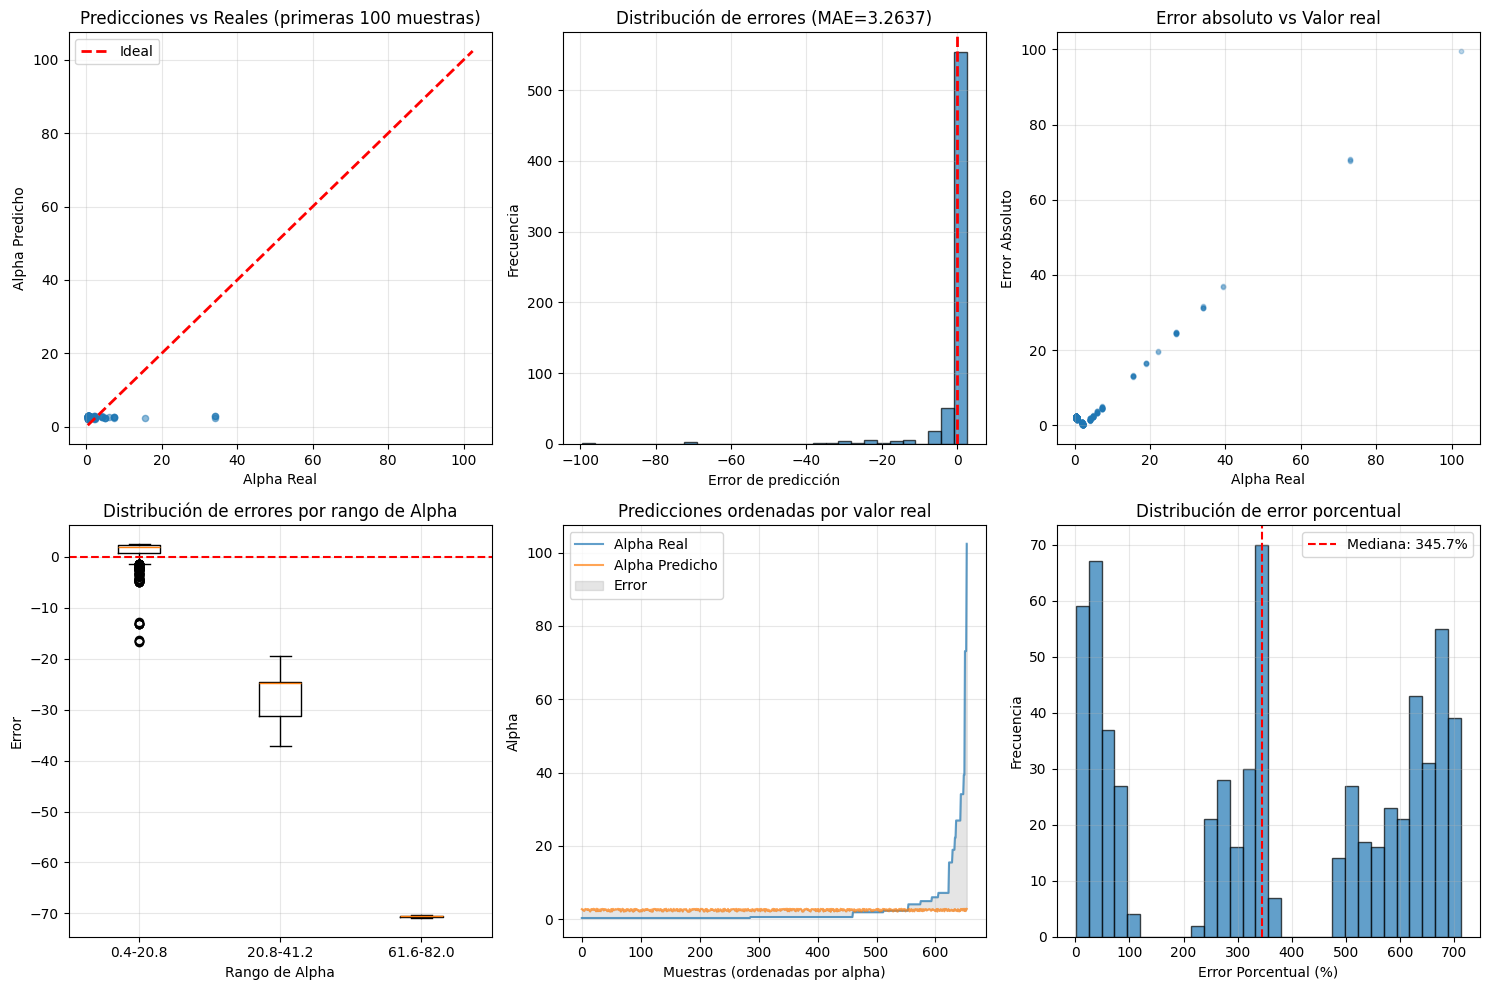


📊 Guardando gráficos individuales...
✅ 02_predicciones_vs_reales_detalle.png
✅ 03_histograma_errores_detalle.png
✅ 04_error_vs_alpha_detalle.png


/tmp/ipykernel_226/872934984.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(error_by_quintile, labels=quintile_labels,


✅ 05_boxplot_quintiles.png
✅ 06_evolucion_comparacion.png
✅ 07_error_porcentual_detalle.png
✅ 08_resumen_estadistico.png
✅ datos_predicciones.csv

🎉 Total imágenes guardadas: 8 + 1 resumen principal
📁 Todas guardadas en: predicciones_modelo_20251215_141700/

Ejemplos de predicción (primeras 10 muestras de test):
Índice   Alpha Real   Alpha Predicho Error      Error %   
------------------------------------------------------------
0        0.6252       2.6634         2.0382     326.04    
1        6.0235       2.6672         -3.3564    55.72     
2        0.3558       2.4790         2.1232     596.73    
3        4.0960       2.5774         -1.5186    37.08     
4        0.6252       2.8491         2.2239     355.74    
5        7.2113       2.5402         -4.6710    64.77     
6        0.3558       2.8364         2.4806     697.18    
7        4.0960       2.6318         -1.4642    35.75     
8        0.3558       2.7750         2.4192     679.92    
9        1.9321       2.2056       

In [ ]:
def visualizar_y_guardar_predicciones(y_true, y_pred, y_train_raw=None, n_samples=100, 
                                      save_images=True, output_dir="predicciones_visualizacion"):
    """
    Visualiza las predicciones vs valores reales y GUARDA las imágenes
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from datetime import datetime
    
    # Configurar para guardar imágenes
    if save_images:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        carpeta = f"{output_dir}_{timestamp}"
        os.makedirs(carpeta, exist_ok=True)
        print(f"📁 Guardando imágenes en: {carpeta}/")
    
    # Calcular MAE dentro de la función
    errors = y_pred - y_true
    abs_errors = np.abs(errors)
    mae_calculado = np.mean(abs_errors)
    
    print(f"📊 Métricas calculadas:")
    print(f"  MAE: {mae_calculado:.4f}")
    print(f"  MSE: {np.mean(errors**2):.4f}")
    print(f"  RMSE: {np.sqrt(np.mean(errors**2)):.4f}")
    
    # Crear figura principal
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Scatter plot predicciones vs reales
    axes[0, 0].scatter(y_true[:n_samples], y_pred[:n_samples], alpha=0.5, s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')
    axes[0, 0].set_xlabel('Alpha Real')
    axes[0, 0].set_ylabel('Alpha Predicho')
    axes[0, 0].set_title('Predicciones vs Reales (primeras 100 muestras)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Histograma de errores
    axes[0, 1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Error de predicción')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title(f'Distribución de errores (MAE={mae_calculado:.4f})')  # Usar MAE calculado
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error absoluto vs valor real
    axes[0, 2].scatter(y_true, abs_errors, alpha=0.3, s=10)
    axes[0, 2].set_xlabel('Alpha Real')
    axes[0, 2].set_ylabel('Error Absoluto')
    axes[0, 2].set_title('Error absoluto vs Valor real')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Boxplot por rangos de alpha
    if y_train_raw is not None:
        # Crear bins para alpha
        n_bins = 5
        bins = np.linspace(y_true.min(), y_true.max(), n_bins + 1)
        bin_indices = np.digitize(y_true, bins) - 1
        
        error_by_bin = []
        bin_labels = []
        
        for i in range(n_bins):
            mask = (bin_indices == i)
            if np.any(mask):
                error_by_bin.append(errors[mask])
                bin_labels.append(f'{bins[i]:.1f}-{bins[i+1]:.1f}')
        
        axes[1, 0].boxplot(error_by_bin, labels=bin_labels)
        axes[1, 0].axhline(y=0, color='r', linestyle='--')
        axes[1, 0].set_xlabel('Rango de Alpha')
        axes[1, 0].set_ylabel('Error')
        axes[1, 0].set_title('Distribución de errores por rango de Alpha')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].axis('off')
    
    # 5. Serie temporal de errores (ordenados por alpha)
    sorted_indices = np.argsort(y_true)
    y_true_sorted = y_true[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    errors_sorted = errors[sorted_indices]
    
    axes[1, 1].plot(y_true_sorted, label='Alpha Real', alpha=0.7)
    axes[1, 1].plot(y_pred_sorted, label='Alpha Predicho', alpha=0.7)
    axes[1, 1].fill_between(range(len(y_true_sorted)), 
                           y_true_sorted, y_pred_sorted, 
                           alpha=0.2, color='gray', label='Error')
    axes[1, 1].set_xlabel('Muestras (ordenadas por alpha)')
    axes[1, 1].set_ylabel('Alpha')
    axes[1, 1].set_title('Predicciones ordenadas por valor real')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Error porcentual
    error_pct = np.abs(errors / y_true) * 100
    valid_mask = ~np.isinf(error_pct) & ~np.isnan(error_pct)
    
    axes[1, 2].hist(error_pct[valid_mask], bins=30, edgecolor='black', alpha=0.7)
    mediana_error = np.median(error_pct[valid_mask])
    axes[1, 2].axvline(x=mediana_error, color='r', 
                      linestyle='--', label=f'Mediana: {mediana_error:.1f}%')
    axes[1, 2].set_xlabel('Error Porcentual (%)')
    axes[1, 2].set_ylabel('Frecuencia')
    axes[1, 2].set_title('Distribución de error porcentual')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar figura principal
    if save_images:
        plt.savefig(f'{carpeta}/01_resumen_completo.png', dpi=300, bbox_inches='tight')
        print("✅ 01_resumen_completo.png")
    
    plt.show()
    
    # ===========================================================
    # GUARDAR GRÁFICOS INDIVIDUALES (CALIDAD SUPERIOR)
    # ===========================================================
    
    if save_images:
        print("\n📊 Guardando gráficos individuales...")
        
        # Gráfico 1: Predicciones vs Reales (alta calidad)
        plt.figure(figsize=(10, 8))
        plt.scatter(y_true[:n_samples], y_pred[:n_samples], alpha=0.6, s=30, 
                   c='blue', edgecolors='black', linewidths=0.5)
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, 
                label='Predicción perfecta', alpha=0.8)
        
        # Añadir línea de regresión
        from scipy import stats
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(y_true, y_pred)
            x_line = np.array([min_val, max_val])
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, 'g-', lw=2, 
                    label=f'Regresión (R={r_value:.3f})', alpha=0.7)
        except:
            pass
        
        plt.xlabel('Alpha Real', fontsize=12)
        plt.ylabel('Alpha Predicho', fontsize=12)
        plt.title('Predicciones vs Valores Reales', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta}/02_predicciones_vs_reales_detalle.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ 02_predicciones_vs_reales_detalle.png")
        
        # Gráfico 2: Histograma de errores detallado
        plt.figure(figsize=(10, 6))
        n, bins, patches = plt.hist(errors, bins=50, edgecolor='black', 
                                   alpha=0.7, color='skyblue', density=True)
        
        # Añadir distribución normal
        try:
            from scipy.stats import norm
            mu, std = np.mean(errors), np.std(errors)
            x = np.linspace(min(errors), max(errors), 100)
            p = norm.pdf(x, mu, std)
            plt.plot(x, p, 'r-', linewidth=3, label=f'Normal (μ={mu:.3f}, σ={std:.3f})')
        except:
            pass
        
        plt.axvline(x=0, color='black', linestyle='--', linewidth=2, 
                   label='Error cero')
        plt.axvline(x=np.mean(errors), color='green', linestyle='-', linewidth=2, 
                   label=f'Media={np.mean(errors):.3f}')
        
        plt.xlabel('Error (Predicho - Real)', fontsize=12)
        plt.ylabel('Densidad', fontsize=12)
        plt.title('Distribución de Errores de Predicción', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta}/03_histograma_errores_detalle.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ 03_histograma_errores_detalle.png")
        
        # Gráfico 3: Error absoluto vs Alpha real
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(y_true, abs_errors, alpha=0.4, s=15, 
                            c=abs_errors, cmap='viridis')
        
        # Añadir media móvil
        sorted_idx = np.argsort(y_true)
        window_size = max(1, len(y_true) // 20)
        ma_errors = np.convolve(abs_errors[sorted_idx], 
                               np.ones(window_size)/window_size, 
                               mode='valid')
        ma_alphas = np.convolve(y_true[sorted_idx], 
                               np.ones(window_size)/window_size, 
                               mode='valid')
        
        plt.plot(ma_alphas, ma_errors, 'r-', linewidth=3, 
                label=f'Media móvil (ventana={window_size})')
        
        plt.colorbar(scatter, label='Error Absoluto')
        plt.xlabel('Alpha Real', fontsize=12)
        plt.ylabel('Error Absoluto', fontsize=12)
        plt.title('Error Absoluto vs Valor Real de Alpha', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta}/04_error_vs_alpha_detalle.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ 04_error_vs_alpha_detalle.png")
        
        # Gráfico 4: Boxplot detallado por quintiles
        plt.figure(figsize=(10, 6))
        
        # Usar quintiles en lugar de bins iguales
        quintiles = np.percentile(y_true, [0, 20, 40, 60, 80, 100])
        error_by_quintile = []
        quintile_labels = []
        
        for i in range(len(quintiles)-1):
            mask = (y_true >= quintiles[i]) & (y_true < quintiles[i+1])
            if np.sum(mask) > 0:
                error_by_quintile.append(errors[mask])
                quintile_labels.append(f'Q{i+1}\n({quintiles[i]:.2f}-{quintiles[i+1]:.2f})')
        
        if error_by_quintile:  # Solo si hay datos
            box = plt.boxplot(error_by_quintile, labels=quintile_labels, 
                             patch_artist=True)
            
            # Colorear las cajas
            colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink']
            for patch, color in zip(box['boxes'], colors[:len(error_by_quintile)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            plt.axhline(y=0, color='red', linestyle='--', linewidth=2, 
                       label='Error cero')
            plt.xlabel('Quintil de Alpha (Q1=menor, Q5=mayor)', fontsize=12)
            plt.ylabel('Error de Predicción', fontsize=12)
            plt.title('Distribución de Errores por Quintil de Alpha', 
                     fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3, axis='y')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'{carpeta}/05_boxplot_quintiles.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()
            print("✅ 05_boxplot_quintiles.png")
        
        # Gráfico 5: Evolución temporal ordenada
        plt.figure(figsize=(12, 6))
        
        # Suavizar las líneas
        window = max(1, len(y_true_sorted) // 50)
        y_true_smooth = np.convolve(y_true_sorted, np.ones(window)/window, mode='valid')
        y_pred_smooth = np.convolve(y_pred_sorted, np.ones(window)/window, mode='valid')
        x_smooth = np.arange(len(y_true_smooth))
        
        plt.plot(x_smooth, y_true_smooth, 'b-', linewidth=2, 
                label='Alpha Real (suavizado)', alpha=0.8)
        plt.plot(x_smooth, y_pred_smooth, 'r-', linewidth=2, 
                label='Alpha Predicho (suavizado)', alpha=0.8)
        
        # Área de error
        plt.fill_between(x_smooth, y_true_smooth, y_pred_smooth, 
                        alpha=0.2, color='gray', label='Error')
        
        plt.xlabel('Muestras (ordenadas por alpha real)', fontsize=12)
        plt.ylabel('Alpha', fontsize=12)
        plt.title('Comparación Alpha Real vs Predicho (ordenado y suavizado)', 
                 fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{carpeta}/06_evolucion_comparacion.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ 06_evolucion_comparacion.png")
        
        # Gráfico 6: Error porcentual detallado
        plt.figure(figsize=(10, 6))
        
        # Filtrar valores extremos para visualización
        if len(error_pct[valid_mask]) > 0:
            max_display_pct = np.percentile(error_pct[valid_mask], 95)
            display_mask = valid_mask & (error_pct <= max_display_pct)
            
            hist_data = error_pct[display_mask]
            n, bins, patches = plt.hist(hist_data, bins=40, edgecolor='black', 
                                       alpha=0.7, color='orange', density=False)
            
            # Estadísticas
            mean_pct = np.mean(hist_data)
            median_pct = np.median(hist_data)
            std_pct = np.std(hist_data)
            
            plt.axvline(x=median_pct, color='red', linestyle='--', linewidth=3,
                       label=f'Mediana: {median_pct:.1f}%')
            plt.axvline(x=mean_pct, color='blue', linestyle='-', linewidth=2,
                       label=f'Media: {mean_pct:.1f}%')
            plt.axvline(x=mean_pct + std_pct, color='green', linestyle=':', linewidth=1.5,
                       label=f'±1σ: {std_pct:.1f}%')
            plt.axvline(x=mean_pct - std_pct, color='green', linestyle=':', linewidth=1.5)
            
            plt.xlabel('Error Porcentual Absoluto (%)', fontsize=12)
            plt.ylabel('Frecuencia', fontsize=12)
            plt.title('Distribución de Error Porcentual', fontsize=14, fontweight='bold')
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{carpeta}/07_error_porcentual_detalle.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()
            print("✅ 07_error_porcentual_detalle.png")
        
        # Gráfico 8: Resumen de métricas
        plt.figure(figsize=(12, 8))
        
        # Calcular todas las métricas
        try:
            from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
            
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_true, y_pred)
        except:
            # Calcular manualmente si sklearn no está disponible
            mae = mae_calculado
            mse = np.mean(errors**2)
            rmse = np.sqrt(mse)
            
            # R² manual
            ss_res = np.sum(errors**2)
            ss_tot = np.sum((y_true - np.mean(y_true))**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        
        # Subplot 1: Métricas principales
        plt.subplot(2, 2, 1)
        metrics = ['MAE', 'RMSE', 'R²']
        values = [mae, rmse, r2]
        colors = ['blue', 'orange', 'green']
        
        bars = plt.bar(metrics, values, color=colors, alpha=0.7)
        for bar, val in zip(bars, values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=10)
        
        plt.title('Métricas Principales', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Subplot 2: Distribución comparativa
        plt.subplot(2, 2, 2)
        plt.hist(y_true, bins=30, alpha=0.5, label='Real', edgecolor='black')
        plt.hist(y_pred, bins=30, alpha=0.5, label='Predicho', edgecolor='black')
        plt.xlabel('Alpha')
        plt.ylabel('Frecuencia')
        plt.title('Distribución Alpha Real vs Predicho', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 3: Error por percentil de alpha
        plt.subplot(2, 2, 3)
        percentiles = np.percentile(y_true, np.linspace(0, 100, 11))
        mae_by_percentile = []
        
        for i in range(len(percentiles)-1):
            mask = (y_true >= percentiles[i]) & (y_true < percentiles[i+1])
            if np.any(mask):
                mae_by_percentile.append(np.mean(abs_errors[mask]))
        
        if mae_by_percentile:
            x_labels = [f'P{int(p)}' for p in np.linspace(0, 100, 11)[:-1]]
            plt.bar(x_labels[:len(mae_by_percentile)], mae_by_percentile, 
                   alpha=0.7, color='purple')
            plt.xlabel('Percentil de Alpha')
            plt.ylabel('MAE')
            plt.title('MAE por Percentil de Alpha', fontsize=12, fontweight='bold')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3, axis='y')
        
        # Subplot 4: Resumen estadístico
        plt.subplot(2, 2, 4)
        plt.axis('off')
        
        error_pct_mean = np.mean(error_pct[valid_mask]) if len(error_pct[valid_mask]) > 0 else 0
        
        stats_text = f"""
        RESUMEN ESTADÍSTICO
        
        Muestras evaluadas: {len(y_true)}
        
        MÉTRICAS:
        • MAE:  {mae:.4f}
        • RMSE: {rmse:.4f}
        • R²:   {r2:.4f}
        • Error % medio: {error_pct_mean:.1f}%
        
        ESTADÍSTICAS ERROR:
        • Media error: {np.mean(errors):.4f}
        • Std error:   {np.std(errors):.4f}
        • Error máximo: {np.max(abs_errors):.4f}
        • Error mínimo: {np.min(abs_errors):.4f}
        
        CORRELACIÓN:
        • Pearson: {np.corrcoef(y_true, y_pred)[0,1]:.4f}
        """
        
        plt.text(0.1, 0.95, stats_text, fontsize=10, 
                verticalalignment='top', family='monospace')
        
        plt.suptitle('RESUMEN COMPLETO DE EVALUACIÓN', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{carpeta}/08_resumen_estadistico.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ 08_resumen_estadistico.png")
        
        # Guardar datos en archivo CSV
        try:
            import pandas as pd
            df_results = pd.DataFrame({
                'alpha_real': y_true,
                'alpha_predicho': y_pred,
                'error': errors,
                'error_absoluto': abs_errors,
                'error_porcentual': error_pct
            })
            df_results.to_csv(f'{carpeta}/datos_predicciones.csv', index=False)
            print("✅ datos_predicciones.csv")
        except:
            pass
        
        # Guardar resumen en archivo de texto
        with open(f'{carpeta}/resumen_evaluacion.txt', 'w') as f:
            f.write("RESUMEN DE EVALUACIÓN DEL MODELO\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Muestras evaluadas: {len(y_true)}\n\n")
            f.write("MÉTRICAS:\n")
            f.write(f"  MAE:  {mae:.6f}\n")
            f.write(f"  MSE:  {np.mean(errors**2):.6f}\n")
            f.write(f"  RMSE: {np.sqrt(np.mean(errors**2)):.6f}\n")
            f.write(f"  R²:   {r2:.6f}\n\n")
            f.write("ESTADÍSTICAS DE ERROR:\n")
            f.write(f"  Media: {np.mean(errors):.6f}\n")
            f.write(f"  Desviación estándar: {np.std(errors):.6f}\n")
            f.write(f"  Mínimo: {np.min(errors):.6f}\n")
            f.write(f"  Máximo: {np.max(errors):.6f}\n")
            f.write(f"  Mediana absoluta: {np.median(abs_errors):.6f}\n\n")
            
            if len(error_pct[valid_mask]) > 0:
                f.write("ERROR PORCENTUAL:\n")
                f.write(f"  Media: {np.mean(error_pct[valid_mask]):.2f}%\n")
                f.write(f"  Mediana: {np.median(error_pct[valid_mask]):.2f}%\n")
        
        print(f"\n🎉 Total imágenes guardadas: 8 + 1 resumen principal")
        print(f"📁 Todas guardadas en: {carpeta}/")
    
    # Mostrar ejemplos específicos
    print("\n" + "=" * 60)
    print("Ejemplos de predicción (primeras 10 muestras de test):")
    print(f"{'Índice':<8} {'Alpha Real':<12} {'Alpha Predicho':<14} {'Error':<10} {'Error %':<10}")
    print("-" * 60)
    
    for i in range(min(10, len(y_true))):
        error = y_pred[i] - y_true[i]
        error_pct_i = abs(error / y_true[i]) * 100 if y_true[i] != 0 else np.inf
        print(f"{i:<8} {y_true[i]:<12.4f} {y_pred[i]:<14.4f} {error:<10.4f} {error_pct_i:<10.2f}")
    
    if save_images:
        return carpeta
    else:
        return None

# ===========================================================
# USO: Versión corregida que calcula MAE internamente
# ===========================================================

print("🚀 EJECUTANDO VISUALIZACIÓN CON GUARDADO AUTOMÁTICO...")
print("=" * 60)

# Asegurarse de que y_true y y_pred existen
if 'y_true' in locals() and 'y_pred' in locals():
    print(f"✅ Datos encontrados: {len(y_true)} predicciones")
    
    # Usar así (guarda automáticamente):
    carpeta_resultados = visualizar_y_guardar_predicciones(
        y_true=y_true,
        y_pred=y_pred,
        y_train_raw=y_train if 'y_train' in locals() else None,  # Opcional
        n_samples=100,
        save_images=True,
        output_dir="predicciones_modelo"
    )
    
    print(f"\n✨ Visualización completada!")
    
    # Para Google Colab: descargar carpeta
    try:
        from google.colab import files
        import zipfile
        
        if carpeta_resultados:
            print(f"\n🔄 Preparando descarga para Google Colab...")
            
            zip_name = f"{carpeta_resultados}.zip"
            with zipfile.ZipFile(zip_name, 'w') as zipf:
                for root, dirs, files_list in os.walk(carpeta_resultados):
                    for file in files_list:
                        filepath = os.path.join(root, file)
                        arcname = os.path.relpath(filepath, carpeta_resultados)
                        zipf.write(filepath, arcname)
            
            files.download(zip_name)
            print(f"📥 Descargando: {zip_name}")
    except NameError:
        pass
    
else:
    print("❌ ERROR: No se encontraron y_true o y_pred")
    print("   Ejecuta primero la evaluación del modelo:")
    print("   y_true, y_pred, mae_test, rmse_test, r2_test = evaluar_modelo(...)")